# Problem 1

# Gillespie's Algoritm and Stochastic Iteration

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


# Model parameters
N = 10000
beta = 1.0
gamma = 0.3
mu = 5e-4
delta = 0.01
epsilon = delta * 10/N

parameters = [beta,gamma,mu]
# Initial conditions for X, Y and Z
X0 = math.floor(gamma*N/beta)
Y0 = math.ceil(mu*N/gamma)

Z0 = N - X0 - Y0

initials = np.array((X0,Y0,Z0))

# Runtime of the model
t_max = 10 * 365

def generate_event(rates,P,model):
    '''
    Generate a random event, numbered by 'm', according to the Gillespie's algoritm, equation
    '''
    
    if model == 'demography':
        if ((np.cumsum(rates)[0]<P) and (np.cumsum(rates)[1]>=P)):
            m=1
        elif ((np.cumsum(rates)[1]<P) and (np.cumsum(rates)[2]>=P)):
            m=2
        elif ((np.cumsum(rates)[2]<P) and (np.cumsum(rates)[3]>=P)):
            m=3
        elif ((np.cumsum(rates)[3]<P) and (np.cumsum(rates)[4]>=P)):
            m=4
        elif ((np.cumsum(rates)[4]<P) and (np.cumsum(rates)[5]>=P)):
            m=5
        else:
            m=0
            
    if model == 'SIR':
        if ((np.cumsum(rates)[0]<P) and (np.cumsum(rates)[1]>=P)):
            m=1        
        else:
            m=0
            
    if model == 'imports':
        if ((np.cumsum(rates)[0]<P) and (np.cumsum(rates)[1]>=P)):
            m=1
        elif ((np.cumsum(rates)[1]<P) and (np.cumsum(rates)[2]>=P)):
            m=2
        elif ((np.cumsum(rates)[2]<P) and (np.cumsum(rates)[3]>=P)):
            m=3
        elif ((np.cumsum(rates)[3]<P) and (np.cumsum(rates)[4]>=P)):
            m=4
        elif ((np.cumsum(rates)[4]<P) and (np.cumsum(rates)[5]>=P)):
            m=5
        elif ((np.cumsum(rates)[5]<P) and (np.cumsum(rates)[6]>=P)):
            m=6
        elif ((np.cumsum(rates)[6]<P) and (np.cumsum(rates)[7]>=P)):
            m=7
        else:
            m=0
        
    return(m)

def stochastic_eqs(N,initials,model):
    '''
    Stochastic equations for various models with model-specific events, with event-corresponding integer 'changes' to S, I and R
    '''
    
    V = initials
    
    if model == 'demography':
        rate = np.zeros((6))
        # list of 6 sub-lists corresponding to the 6 respective events. Each sublist is 3 elements long and contains the change in X, Y and Z, as a result of each event
        change = np.zeros((6,3))

        # We define 6 events, transmission, recovery, birth of a person, death of a susceptible, death of an infected and death of a recovered
        rate[0] = beta * V[0] * V[1]/N
        change[0,:] = ([-1, +1, 0])

        rate[1] = gamma * V[1]
        change[1,:] = ([0, -1, +1])

        rate[2] = mu * N
        change[2,:] = ([+1, 0, 0])

        rate[3] = mu * V[0]
        change[3,:] = ([-1, 0, 0])

        rate[4] = mu * V[1]
        change[4,:] = ([0, -1, 0])

        rate[5] = mu * V[2]
        change[5,:] = ([0, 0, -1])
    
    if model == 'SIR':
        rate = np.zeros((2))
        change = np.zeros((2,3))
        
        rate[0] = beta * V[0] * V[1]/N
        change[0,:] = ([-1, +1, 0])

        rate[1] = gamma * V[1]
        change[1,:] = ([0, -1, +1])
        
    if model == 'imports':
        rate = np.zeros((8))
        change = np.zeros((8,3))
        
        rate[0] = beta * V[0] * V[1]/N;  change[0,:]=([-1, +1, 0]);
        rate[1] = gamma * V[1];  change[1,:]=([0, -1, +1]);
        rate[2] = mu * N;  change[2,:]=([+1, 0, 0]);
        rate[3] = mu * V[0];  change[3,:]=([-1, 0, 0]);
        rate[4] = mu * V[1];  change[4,:]=([0, -1, 0]);
        rate[5] = mu * V[2];  change[5,:]=([0, 0, -1]);
        rate[6] = epsilon * V[0];  change[6,:]=[-1, +1, 0];
        rate[7] = delta;  change[7,:]=[0, +1, 0];
    
    if model == 'metapopulation':
        change = np.zeros((pops,2,3))

    # Generate two random numbers
    R1 = random.random()
    R2 = random.random()
    
    rate_sum = np.sum(rate)
    
    dt = -np.log(R2)/(rate_sum)
    
    P = R1 * rate_sum
    
    if model == 'imports':
        m = generate_event(rate, P, 'imports')
        V[range(3)] = V[range(3)] + change[m,:]
        V[3] = 0
        V[4] = 0
        
        if m == 6:
            V[3] = 1
        if m == 6:
            V[4] = 1
    else:     
        m = generate_event(rate, P, model)
        V[range(3)] = V[range(3)] + change[m,:]
        
    return [V, dt]
    

def Stoch_Iteration(N,INPUT,model):
    '''
    Performs stochastic iterations based on the above provided model-specific stochastic equations
    Provides output data for t(years), S, I and R
    '''
    
    T=[0]
    S=[0]
    I=[0]
    R=[0]
    et = [0]
    dt = [0]
    t = 0
    
    T.append(t)
    S.append(INPUT[0])
    I.append(INPUT[1])
    R.append(INPUT[2])
    
    while t < t_max:
        
        [res, ts] = stochastic_eqs(N,INPUT,model)
        t += ts
        T.append(t)
        S.append(res[0])
        I.append(res[1])
        R.append(res[2])
        
        if model == 'imports':
            et.append(res[3])
            dt.append(res[4])      
            
    tT=np.array(T)[1:,]/365.
    tS=np.array(S)[1:,]
    tI=np.array(I)[1:,]
    tR=np.array(R)[1:,]
    
    if model == 'imports':
        return [tT,tS,tI,tR, et, dt]
    else:    
        return [tT,tS,tI,tR]
    
    
def initials_equilibrium(N, model):
    '''
    Defines model-specific initial conditions for a close to equilibrium state, based on an input population size
    '''
    
    if model == 'imports':

        X0 = math.floor(gamma*N/beta)
        Y0 = math.ceil(mu*N/gamma)
        Z0 = N - X0 - Y0
        
        delta = 0.01
        epsilon = delta*10/N
        return np.array((X0,Y0,Z0,0,0,epsilon))
    
    else:
        X0 = math.floor(gamma*N/beta)
        Y0 = math.ceil(mu*N/gamma)
        Z0 = N - X0 - Y0
        initials = np.array((X0,Y0,Z0))
        return initials
    
def initials_deterministic(N, model):
    '''
    Defines model-specific initial conditions for a couple of initial infected in a completely susceptibele population, based on an input population size
    '''
    
    if model == 'imports':

        Y0 = math.ceil(0.01*N)
        X0 = math.floor(N - Y0)
        Z0 = N - X0 - Y0
        
        delta = 0.01
        epsilon = delta*10/N
        return np.array((X0,Y0,Z0,0,0,epsilon))
    
    else:
        Y0 = math.ceil(0.1*N)
        X0 = math.floor(N - Y0)
        Z0 = N - X0 - Y0
        initials = np.array((X0,Y0,Z0))
        
        return initials
    


# Deterministic SIR 

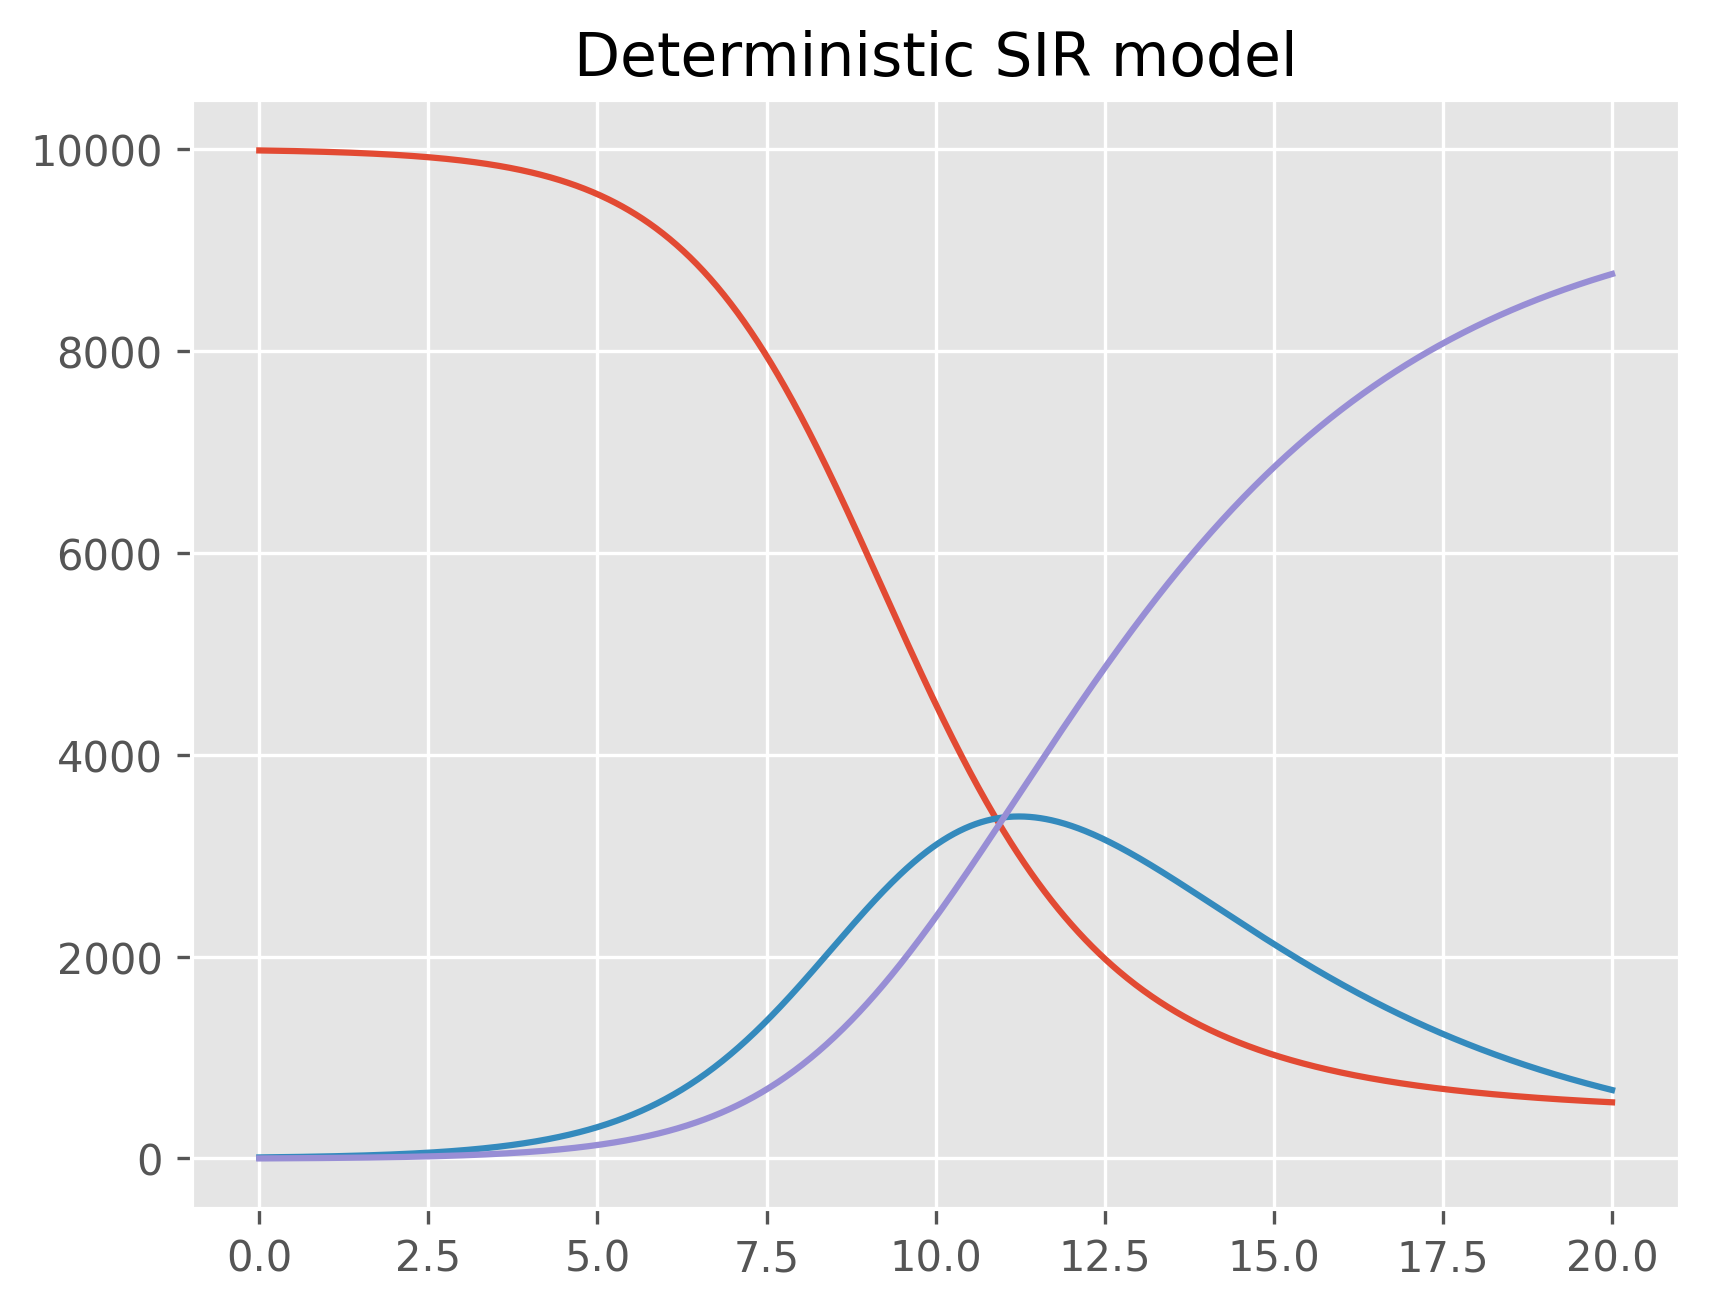

10000 10000


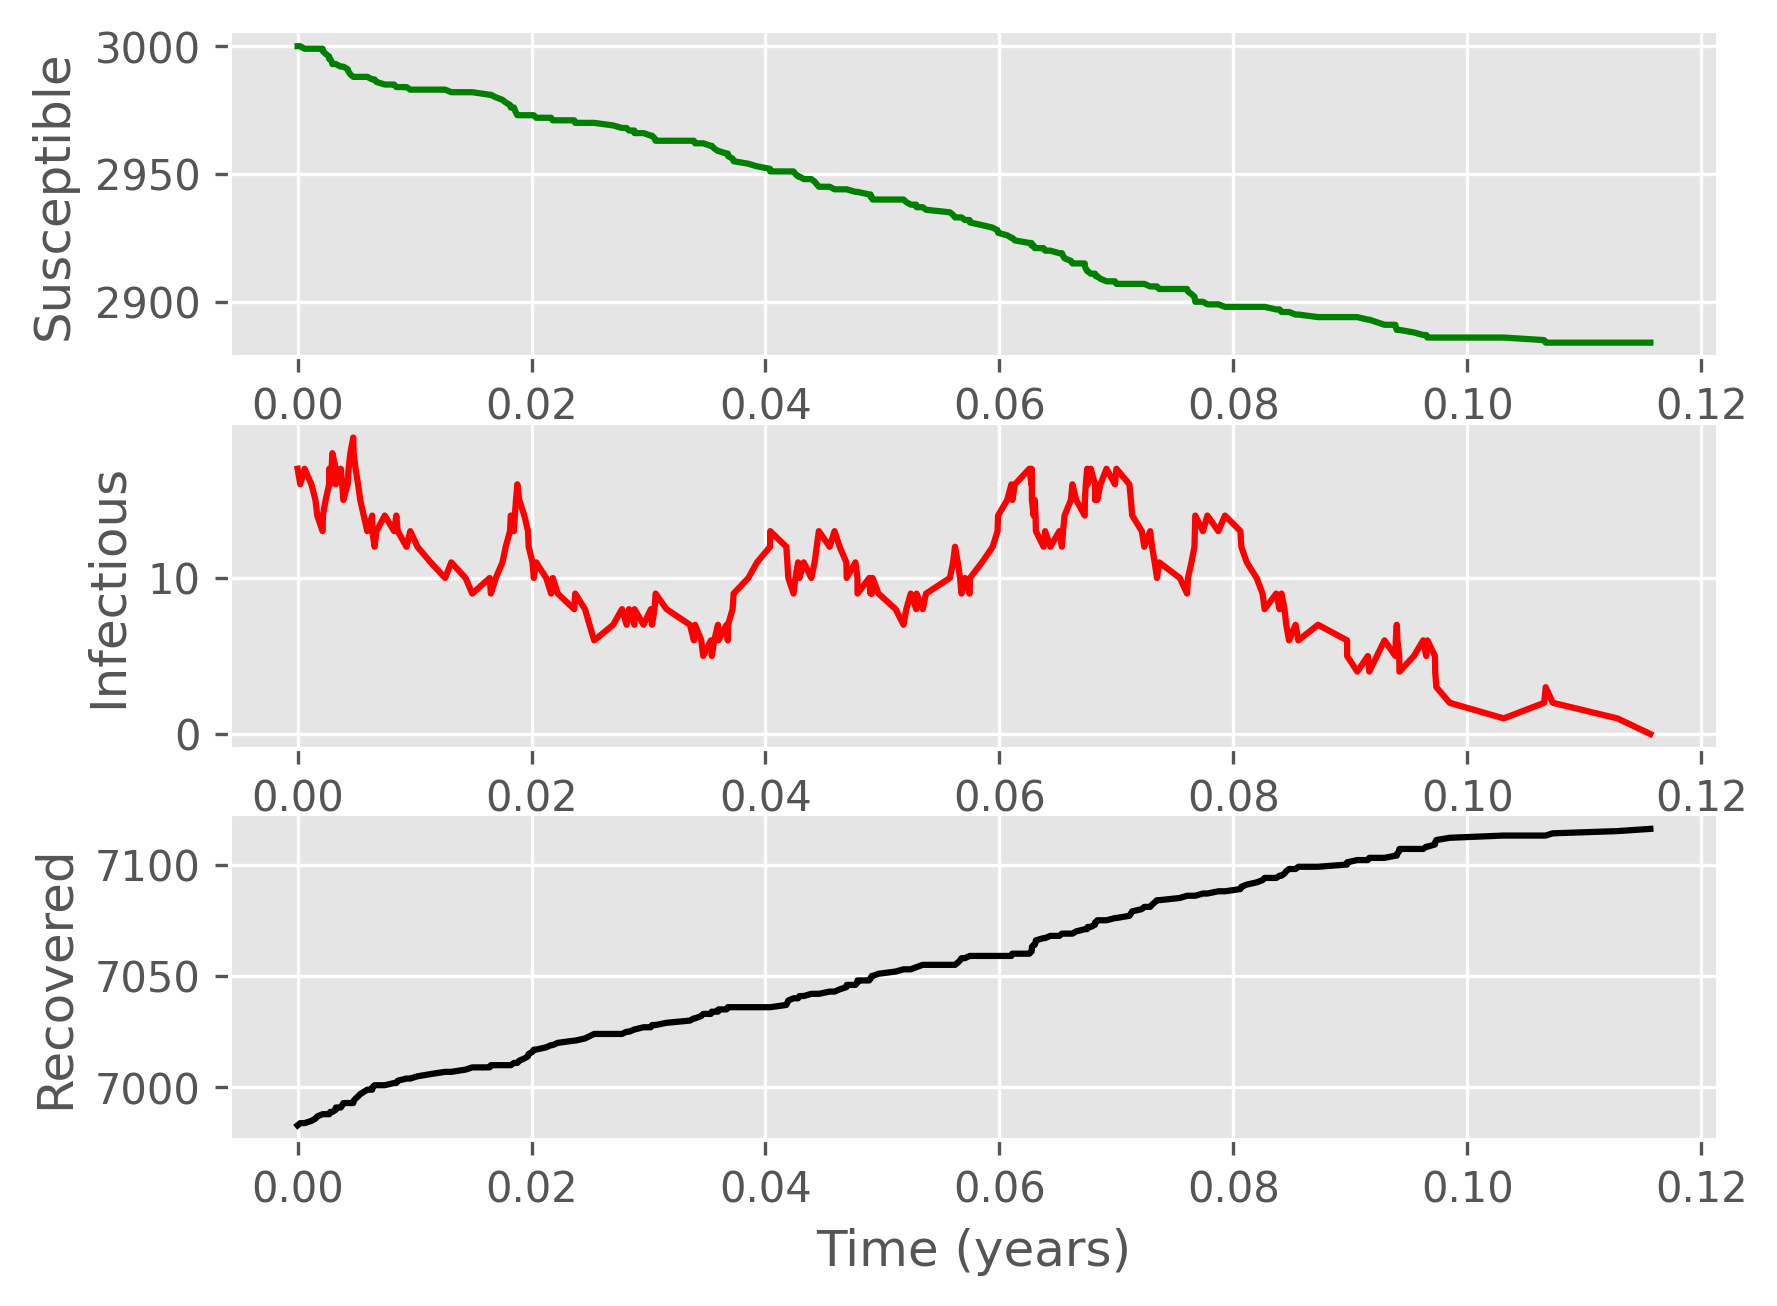

In [2]:
from scipy.integrate import odeint

# Time range for deterministic SIR
t = np.linspace(0,20, num = 1000)

def deterministic_sir(initial, t_list ,model):
    '''
    Deterministic SIR differential equations from assignment 1 with output S, I and R
    '''
    def sir(initial, model, beta, gamma, mu):
        '''
        ODEs provided for sbsequent integration
        '''
        if model == 'SIR':
            mu = 0
            
        S = initial[0]
        I = initial[1]
        R = initial[2]

        dSdt = mu - beta * I * S - mu * S 
        dIdt = beta * I * S - gamma * I - mu * I
        dRdt = gamma * I - mu * R
        
        return ([dSdt, dIdt, dRdt])

    y = odeint(sir, initial, t_list, args=(beta,gamma,mu))
    
    S = np.array((y[:,0]))*N
    I = np.array((y[:,1]))*N
    R = np.array((y[:,2]))*N
    
    return [S,I,R]

initials = [9990/N,10/N,0]

S = deterministic_sir(initials, t ,'demography')[0]
I = deterministic_sir(initials, t ,'demography')[1]
R = deterministic_sir(initials, t ,'demography')[2]

plt.plot(t, S)
plt.plot(t, I)
plt.plot(t, R)
plt.title('Deterministic SIR model')
plt.show()



def plot_model(N, initial, model):

    if model == 'imports':
        [tT,tS,tI,tR, et, dt]=Stoch_Iteration(N, initial, 'imports')
    else: 
        [tT,tS,tI,tR]=Stoch_Iteration(N, initial, model)
    

    print(tS[-1] + tI[-1] + tR[-1], N)

    plt.subplot(311)
    plt.plot(tT, tS, 'g')
#     plt.plot(t, deterministic_sir(initial, model)[0], 'g--')
    #pl.xlabel ('Time (years)')
    plt.ylabel ('Susceptible')
    plt.subplot(312)
    plt.plot(tT, tI, 'r')
#     plt.plot(t, deterministic_sir(initial, model)[1], 'b--')
    #pl.xlabel ('Time (years)')
    plt.ylabel ('Infectious')
    plt.subplot(313)
    plt.plot(tT, tR, 'k')
    plt.xlabel ('Time (years)')
    plt.ylabel ('Recovered')
    plt.show()


N = 10000
X0 = math.floor(gamma*N/beta)
Y0 = math.ceil(mu*N/gamma)
Z0 = N - X0 - Y0
initials = np.array((X0,Y0,Z0))
# initials = np.array((9990,10,0))
# plot_model(np.array((X0,Y0,Z0, 0.0, 0.0)), 'imports')
plot_model(N,initials,'SIR')

# Run multiple stochastic iterations for various models

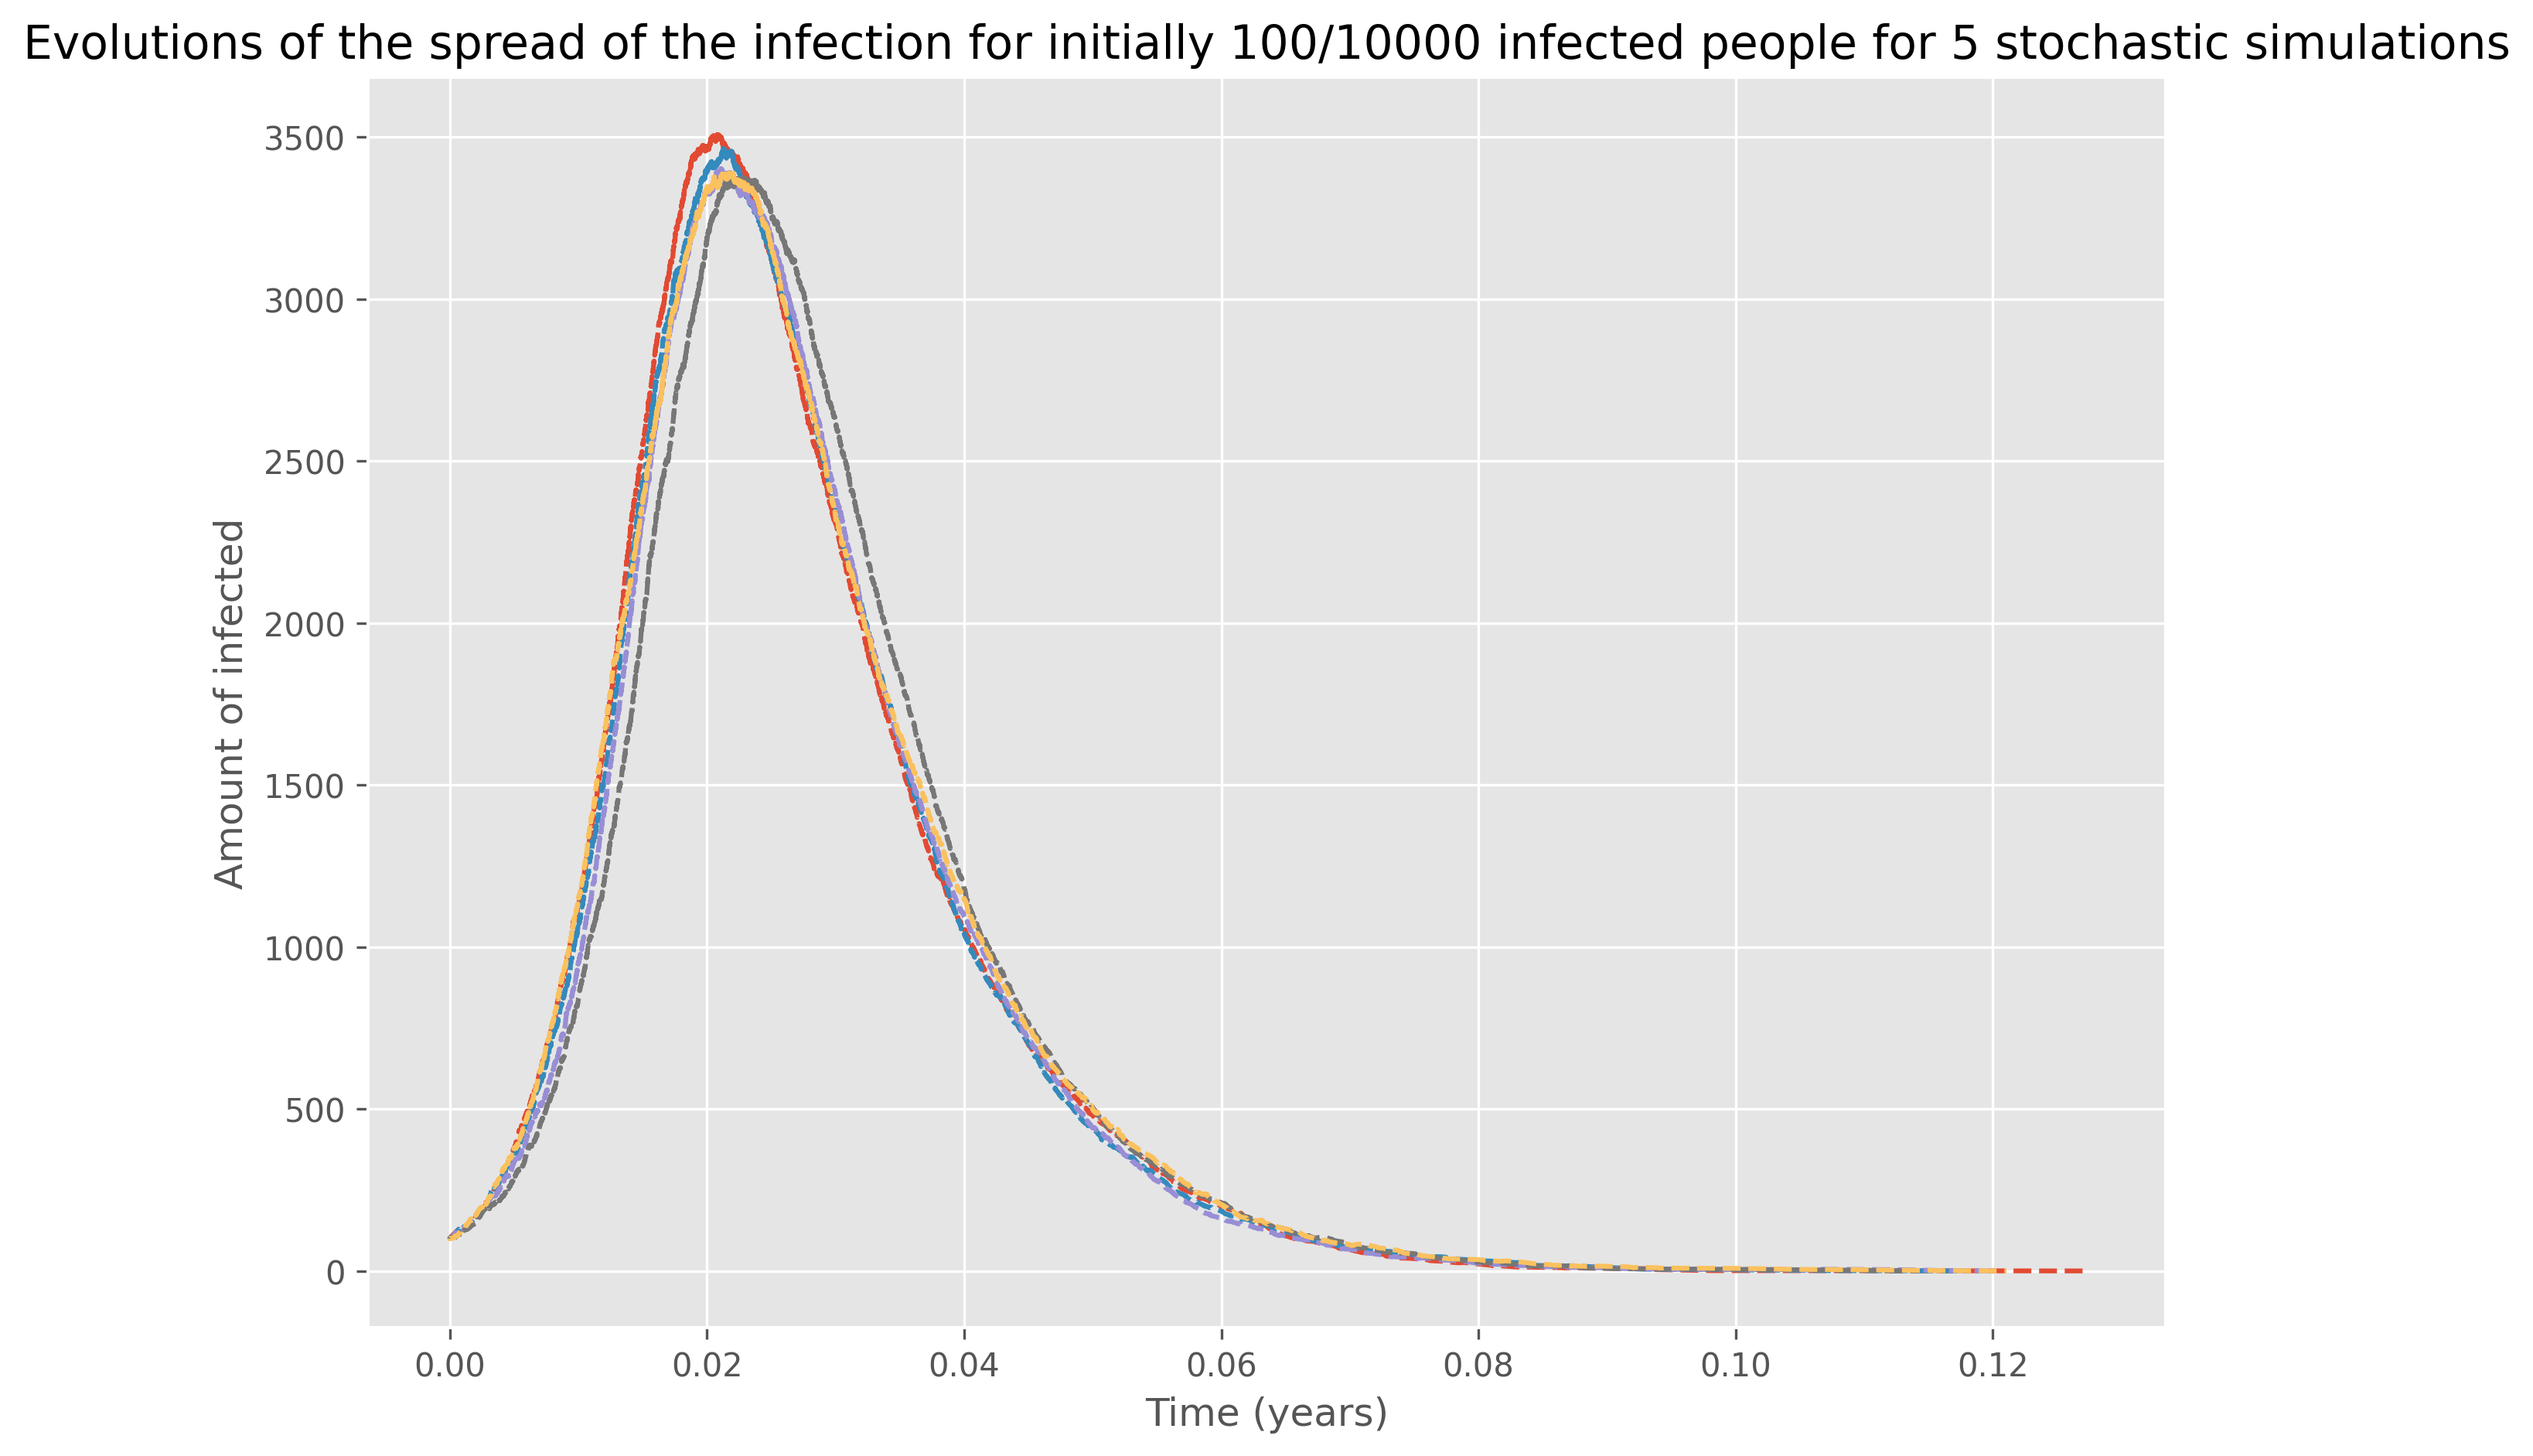

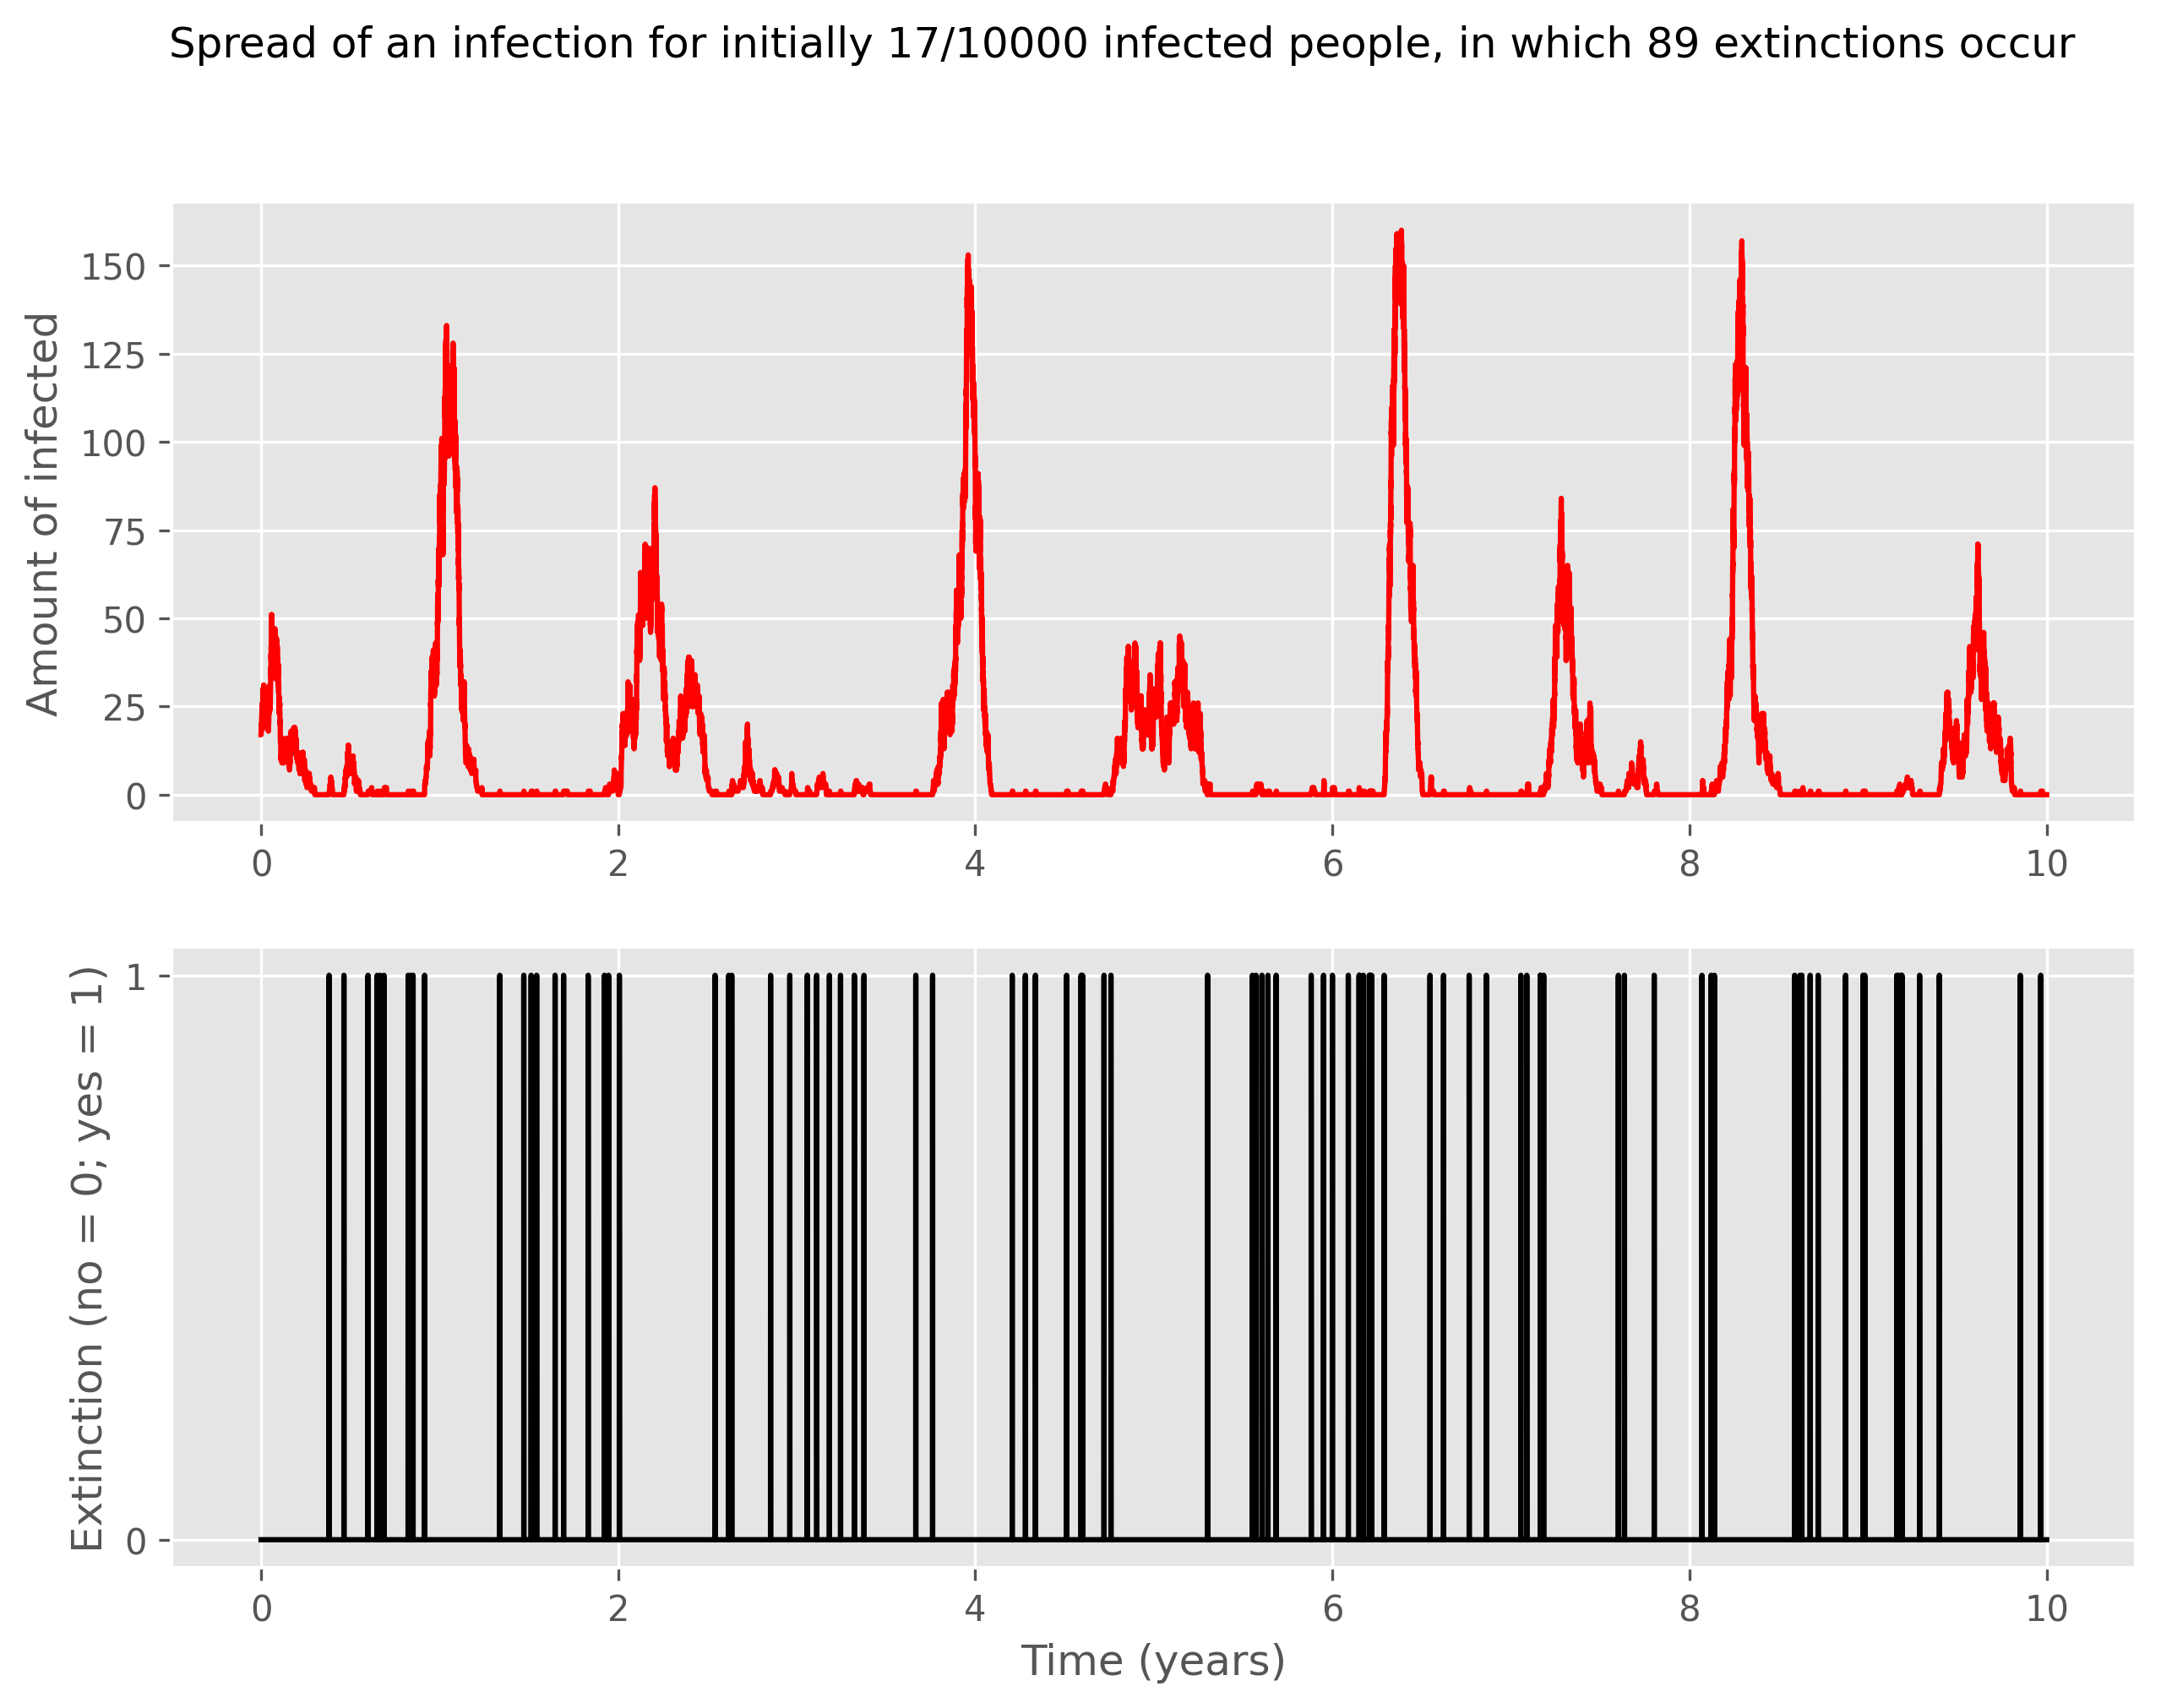

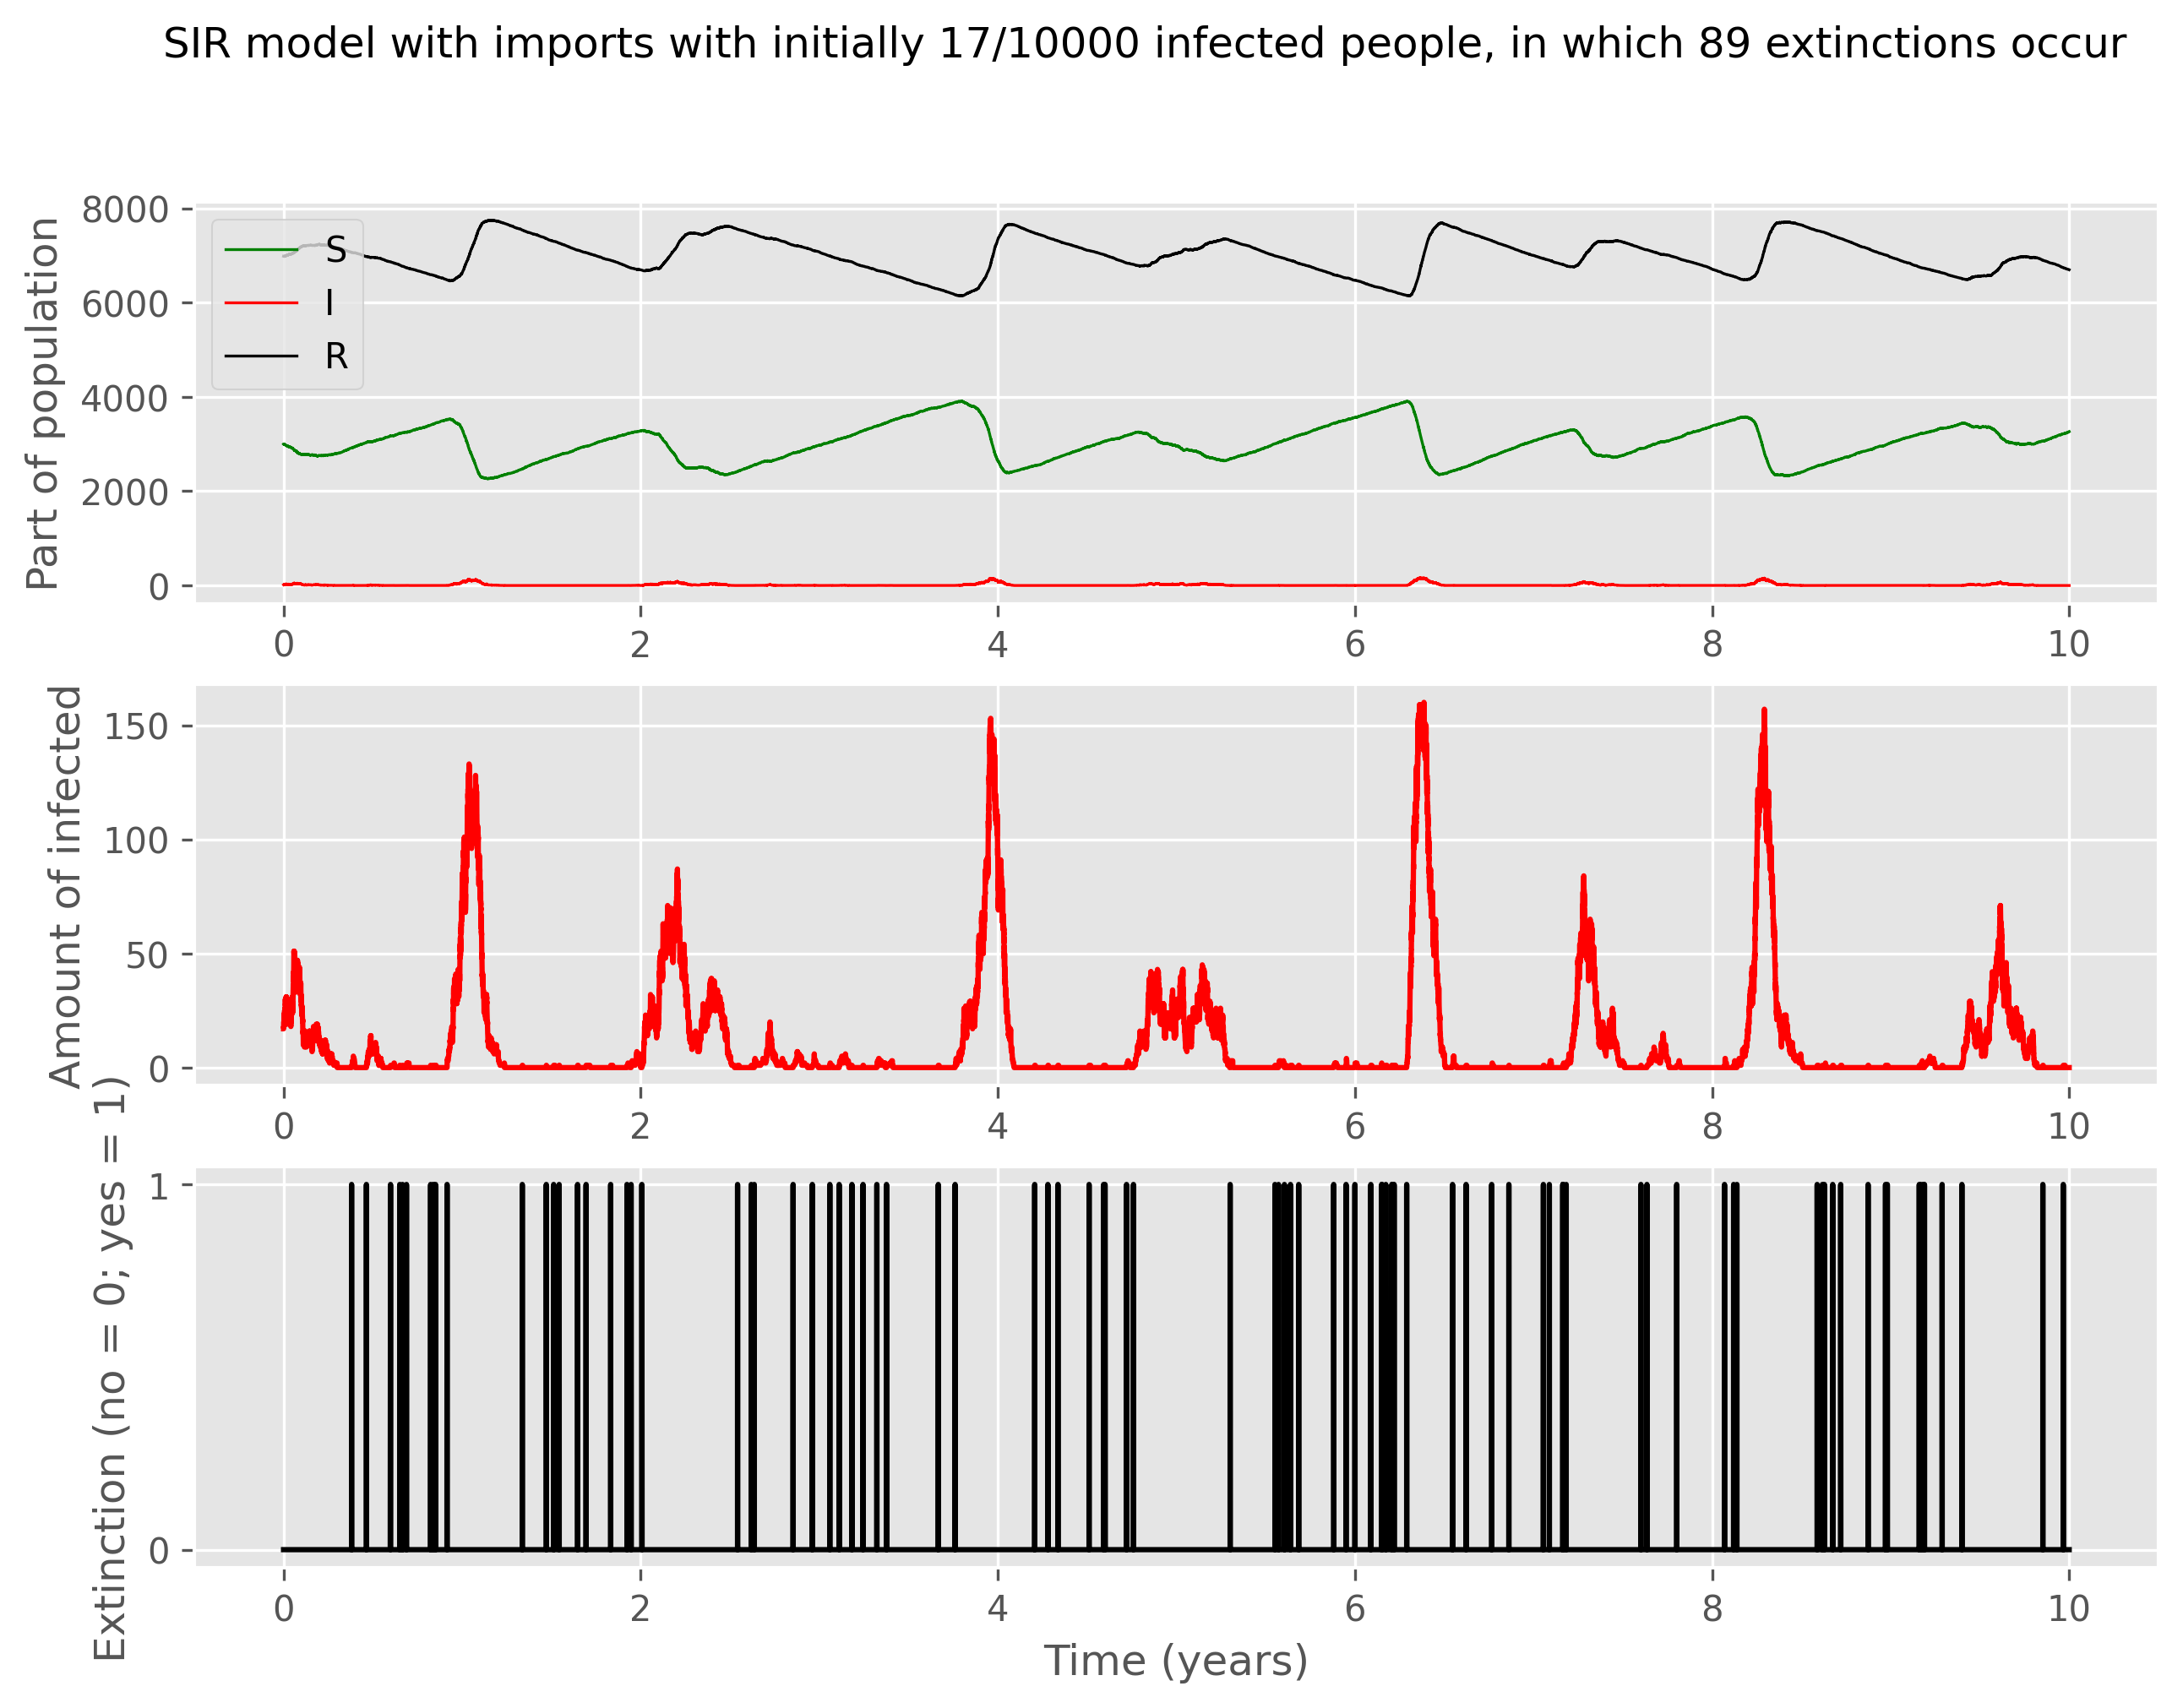

Gamma = 0.3
Covariance = 28, Variance = 42, $\bar{X}$ = 2987.33 $\bar{Y}$ = 12.34 
Covariance = 107, Variance = 1533, $\bar{X}$ = 2933.78 $\bar{Y}$ = 9.43 
Covariance = 51, Variance = 369, $\bar{X}$ = 2967.57 $\bar{Y}$ = 10.85 
Covariance = 24, Variance = 267, $\bar{X}$ = 2975.13 $\bar{Y}$ = 7.75 
Covariance = 91, Variance = 6643, $\bar{X}$ = 2860.04 $\bar{Y}$ = 12.92 
Covariance = 38, Variance = 1459, $\bar{X}$ = 2934.37 $\bar{Y}$ = 14.26 
Covariance = 100, Variance = 1626, $\bar{X}$ = 2927.25 $\bar{Y}$ = 18.50 
Covariance = 169, Variance = 20069, $\bar{X}$ = 2748.72 $\bar{Y}$ = 26.56 
Covariance = 424, Variance = 16705, $\bar{X}$ = 2774.14 $\bar{Y}$ = 15.72 
Covariance = 491, Variance = 22587, $\bar{X}$ = 2733.92 $\bar{Y}$ = 23.17 

 Average over 10 runs covariance = 152.90, X_mean = 2884.23, Y_mean = 15.15


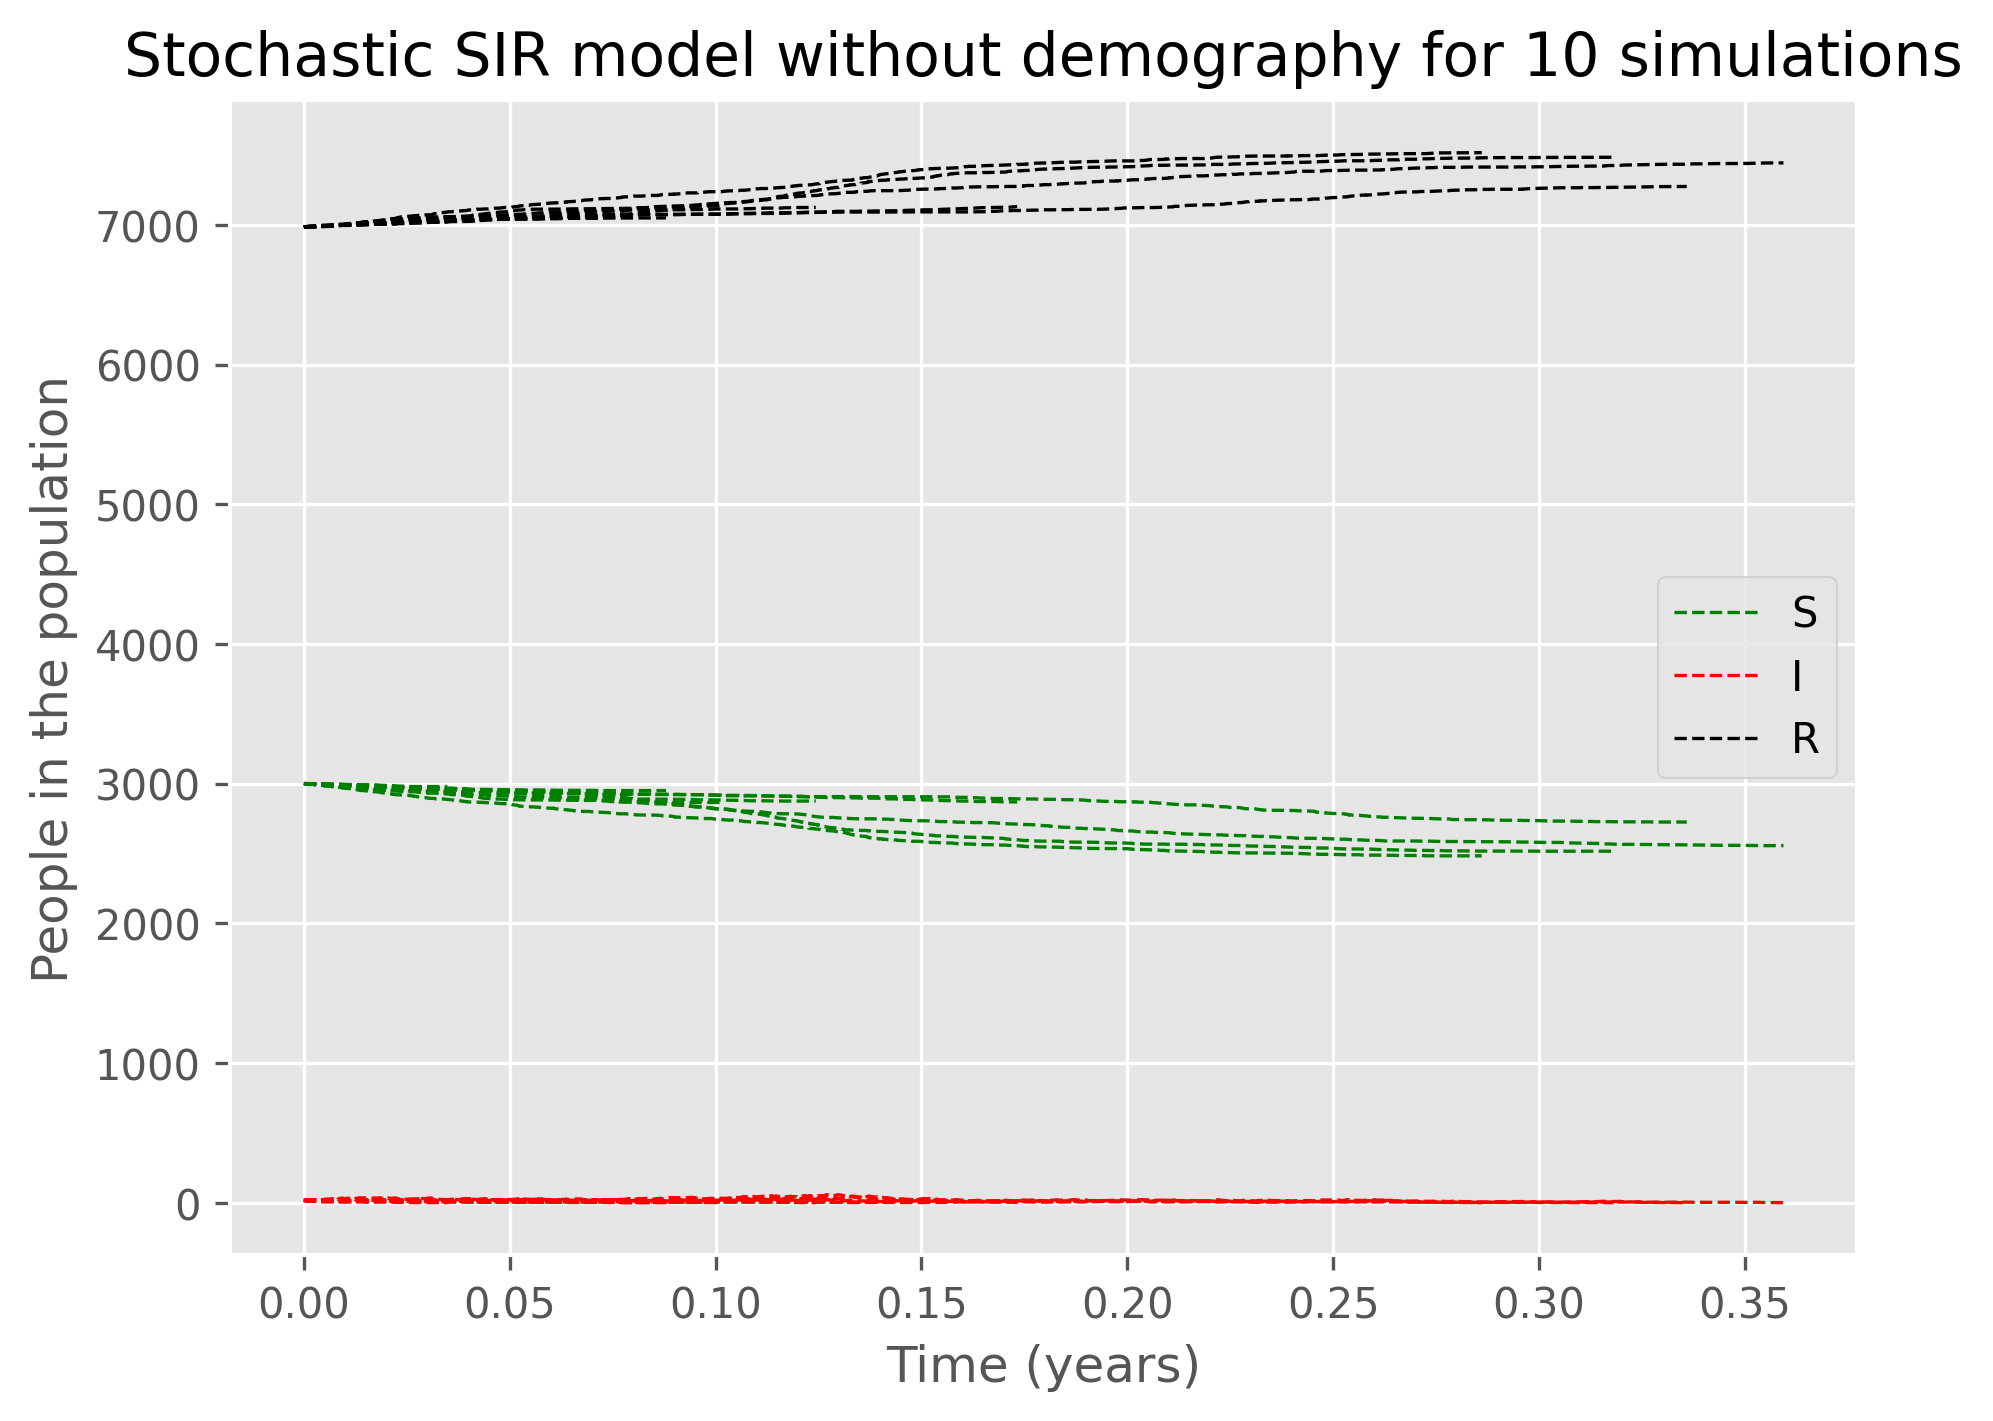

In [3]:

def plot_infected(N, initial, model, runs):
    '''
    Infections evolution for several simulations to demonstrate variability
    '''
    plt.figure(figsize = (10,7))
    
    # For more than 1 provided run, reiterate stochastic equations per run, and plot all results in 1 figure
    if runs > 1:
        for i in range(runs):
            if model == 'imports':
                initials = np.array((initial[0],initial[1],initial[2],initial[3],initial[4]))
                [tT,tS,tI,tR,et,dt]=Stoch_Iteration(N,initials, model)
            else:
                initials = np.array((initial[0],initial[1],initial[2]))
                [tT,tS,tI,tR]=Stoch_Iteration(N, initials, model)

            plt.plot(tT, tI, '--')
    else:
        if model == 'imports':
            initials = np.array((initial[0],initial[1],initial[2],initial[3],initial[4]))
            [tT,tS,tI,tR,et,dt]=Stoch_Iteration(N,initials, model)
        else:
            initials = np.array((initial[0],initial[1],initial[2]))
            [tT,tS,tI,tR]=Stoch_Iteration(N, initials, model)
       
        extinctions = 0
        extinctions_time = np.zeros((len(tI)))
        for i in range(1, len(tI)):
            if tI[i - 1] == 0 and tI[i] > 0:
                extinctions_time[i-1] = 1
                extinctions += 1
                
        plt.subplot(211)
        plt.suptitle(f'Spread of an infection for initially {int(initial[1])}/{N} infected people, in which {extinctions} extinctions occur')       
        plt.plot(tT, tI, 'r-', label = 'I')
        plt.ylabel('Amount of infected')
        plt.subplot(212)
        plt.plot(tT, extinctions_time, 'k-')
        plt.ylabel('Extinction (no = 0; yes = 1)')
        plt.xlabel('Time (years)')
        plt.yticks([0,1])
#         plt.savefig('downloads/extinction.png',dpi=300)
        plt.show()
        
        plt.figure(figsize = (10,7))
        plt.subplot(311)
        if model == 'imports':
            plt.suptitle(f'SIR model with imports with initially {int(initial[1])}/{N} infected people, in which {extinctions} extinctions occur')  
        elif model == 'demography':
            plt.suptitle(f'SIR model with demography with initially {int(initial[1])}/{N} infected people, in which {extinctions} extinctions occur')  
        elif model == 'SIR':
            plt.suptitle(f'Basic SIR model with initially {int(initial[1])}/{N} infected people, in which {extinctions} extinctions occur')  
        
        plt.plot(tT, tS, 'g-', linewidth = 0.8, label = 'S')
        plt.plot(tT, tI, 'r-', linewidth = 0.8, label = 'I')
        plt.plot(tT, tR, 'k-', linewidth = 0.8, label = 'R')
        plt.ylabel('Part of population')
        plt.legend()
        plt.subplot(312)
        plt.plot(tT, tI, 'r-', label = 'I')
        plt.ylabel('Amount of infected')
        plt.subplot(313)
        plt.plot(tT, extinctions_time, 'k-')
        plt.ylabel('Extinction (no = 0; yes = 1)')
        plt.xlabel('Time (years)')
        plt.yticks([0,1])
#         plt.savefig('downloads/sir_extinction.png',dpi=300)
        plt.show()
        print(f'Gamma = {gamma}')
        
        return
    
#     plt.xlim(0,0.1)
    plt.xlabel('Time (years)')
    plt.ylabel('Amount of infected')
    plt.title(f'Evolutions of the spread of the infection for initially {int(initial[1])}/{N} infected people for {runs} stochastic simulations')
#     plt.savefig('downloads/variability.png',dpi=300)
    plt.show()
        
            
def plot_repeated(N, initial, model, runs):
    '''
    Plots multiple runs for SIR model in one graph, and prints (negative) covariances
    '''
    
    plt.figure(figsize = (7,5))
    mean_cov = 0
    S_bar = 0
    I_bar = 0
    for i in range(runs):
        # For each run reiterate stochastic equations to provide new outputs for each run
        if model == 'imports':
            initials = np.array((initial[0],initial[1],initial[2],initial[3],initial[4]))
            [tT,tS,tI,tR,et,dt]=Stoch_Iteration(N,initials, model)
            
        else:
            initials = np.array((initial[0],initial[1],initial[2]))
            [tT,tS,tI,tR]=Stoch_Iteration(N, initials, model)

        # For more than 1 provided run plot all results in 1 figure
        if runs > 1:
            
            if i < runs -1:
                plt.plot(tT, tS, 'g--', linewidth = 0.8)
                plt.plot(tT, tI, 'r--', linewidth = 0.8)
                plt.plot(tT, tR, 'k--', linewidth = 0.8)
            
            else:
                # with the last run plot these just to have a non-repeating label for the plot legends
                plt.plot(tT, tS, 'g--', linewidth = 0.8, label = 'S')
                plt.plot(tT, tI, 'r--', linewidth = 0.8, label = 'I')
                plt.plot(tT, tR, 'k--', linewidth = 0.8, label = 'R')
                plt.legend()
                
            cov = np.cov(tS,tI)[0][1]
            var = np.var(tS)
            mean_cov += cov
            S_bar += np.mean(tS)
            I_bar += np.mean(tI)
            print(r'Covariance = %i, Variance = %i, $\bar{X}$ = %.2f $\bar{Y}$ = %.2f '%(cov,var,np.mean(tS),np.mean(tI)))
        
        else: 
            # for 1 run, plot these to get a label for plot legend.
            plt.plot(tT, tS, 'g--', linewidth = 0.8, label = 'S')
            plt.plot(tT, tI, 'r--', linewidth = 0.8, label = 'I')
            plt.plot(tT, tR, 'k--', linewidth = 0.8, label = 'R')
            plt.legend()

    mean_cov = mean_cov/runs
    S_bar = S_bar/runs
    I_bar = I_bar/runs
    
    print('\n Average over %i runs covariance = %.2f, X_mean = %.2f, Y_mean = %.2f'%(runs,mean_cov,S_bar,I_bar))
    
    plt.xlabel('Time (years)')
    plt.ylabel('People in the population')
    
    if model == 'SIR':
        plt.title('Stochastic SIR model without demography for %i simulations'%(runs))
#         plt.xlim(0,0.14)
#         plt.savefig('downloads/sirmodelstochastic.png',dpi = 300)
    elif model == 'demography':
#         plt.xlim(0,0.08)
        plt.title('Stochastic SIR model with demography for %i simulations'%(runs))
#         plt.savefig('downloads/demographystochastic_normal.png',dpi = 300)
    elif model == 'imports':
        if runs > 1:
            plt.title('Stochastic SIR model with imports and demography for %i simulations'%(runs))
        else:
            plt.title('Stochastic SIR model with imports and demography for 1 simulation')
            
#         plt.xlim(0,0.5)
#         plt.savefig('downloads/stochastic_resonance.png', dpi = 300)
    plt.show()
    
# Variability demonstration for SIR model, to show various stochastic I curves
N = 10000
Y0 = 0.01 * N
X0 = N - Y0
Z0 = N - X0 - Y0
# beta = 1
gamma = 0.3
initials = np.array((X0,Y0,Z0))
initials_imports = initials_deterministic(N,'imports')
plot_infected(N,initials,'SIR',5)

# plot_infected(N,initials_imports,'imports',5)

# plot_repeated(N,initials_imports,'imports',10)

# plot_repeated(N, initials, 'SIR', 10)
# plot_repeated(N, initials, 'demography', 10)




# Plot SIR model, and I curves (seperately), for given population, and amount of runs
# plot_repeated(N, initials_equilibrium(3000,'imports'), 'imports', 8)
# gamma = 0.1
# plot_infected(N, initials_equilibrium(10000,'imports'), 'imports', 1)
# plot_repeated(N, initials_deterministic(10000,'imports'), 'imports', 10)
# plot_repeated(N, initials_equilibrium(10000,'imports'), 'imports', 10)

plot_infected(N, initials_equilibrium(10000,'imports'), 'imports', 1)


# plot_repeated(N, initials_equilibrium(10000,'demography'), 'demography', 10)
plot_repeated(N, initials_equilibrium(10000,'SIR'), 'SIR', 10)




# Extinction, critical community size, first passage time

N = 70000, and initial conditions [S0, I0, R0]  = [21000, 117, 48883]
Extinctions/year = 1.44 averaged over 10 simulations
Average first passage time = 3.801 year 

N = 75000, and initial conditions [S0, I0, R0]  = [22500, 125, 52375]
Extinctions/year = 0.95 averaged over 10 simulations
Average first passage time = 3.590 year 

N = 80000, and initial conditions [S0, I0, R0]  = [24000, 134, 55866]
Extinctions/year = 1.05 averaged over 10 simulations
Average first passage time = 2.955 year 

N = 85000, and initial conditions [S0, I0, R0]  = [25500, 142, 59358]
Extinctions/year = 0.52 averaged over 10 simulations
Average first passage time = 2.733 year 

Approximate critical population size = 74489


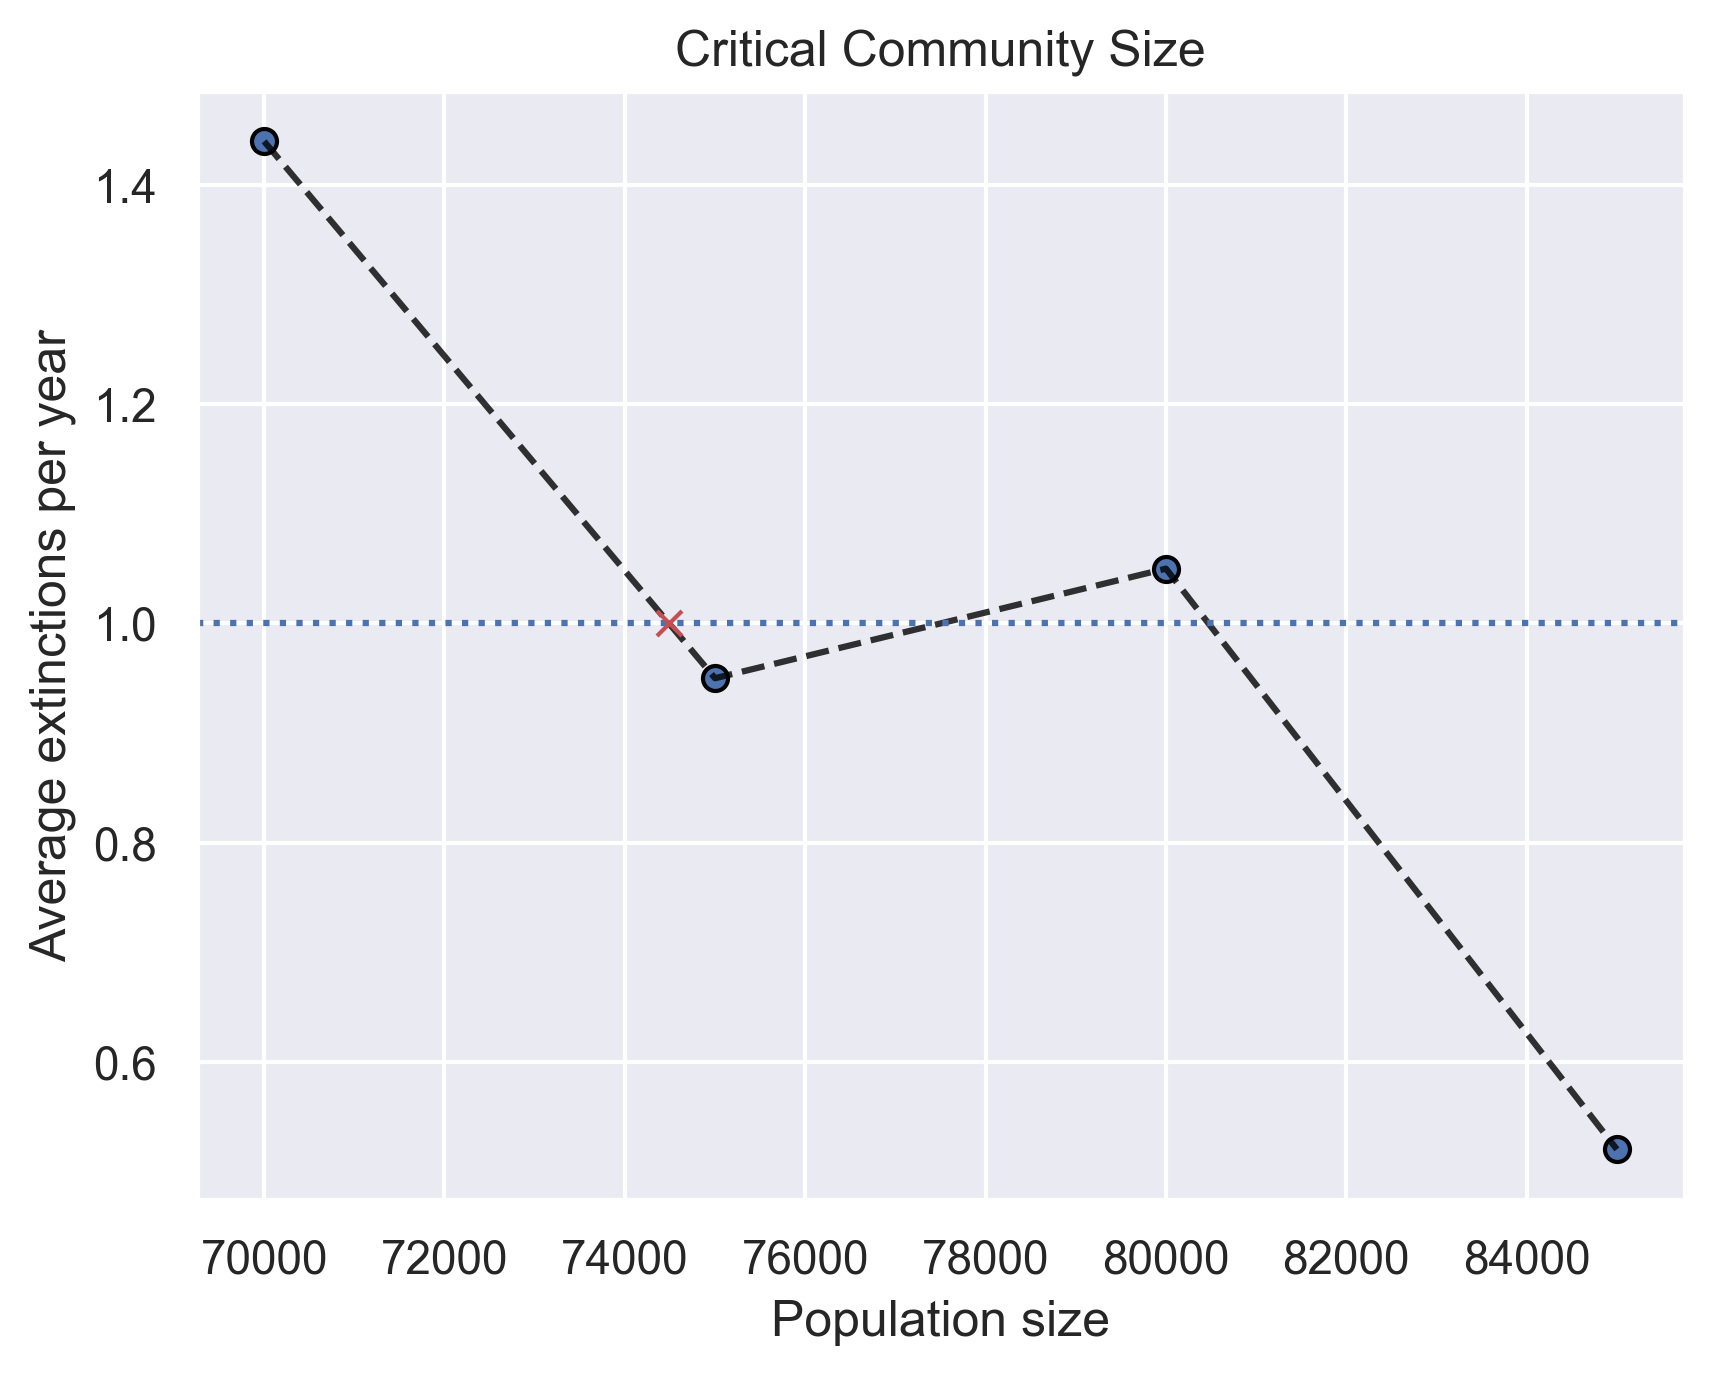

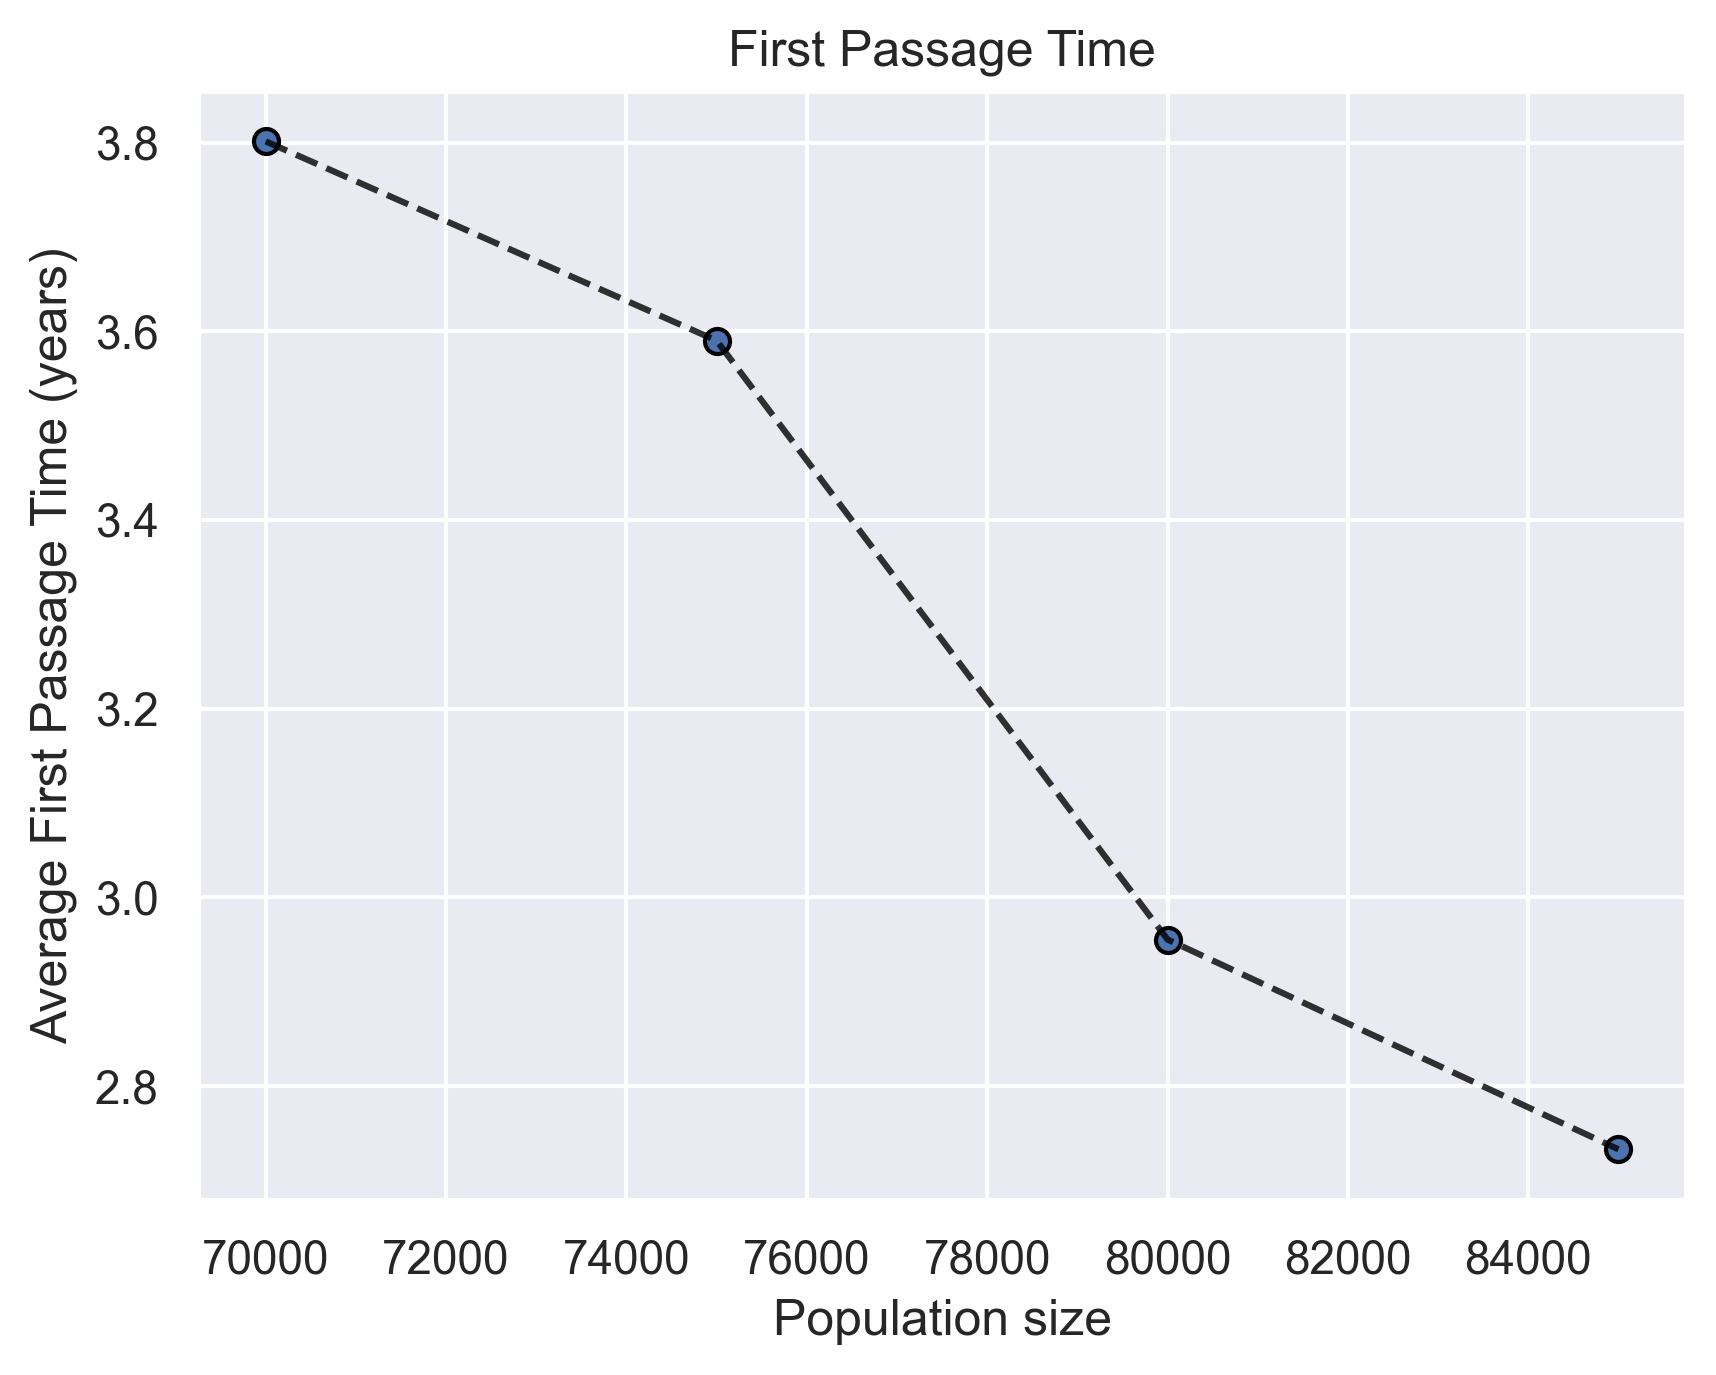

74489.7852197165

In [5]:
def extinction(infected_list):
    '''
    Calculates the amount of extinctions from a list of the amount of infected per time
    '''
    extinctions = 0
    for i in range(1, len(infected_list)):
        if infected_list[i - 1] == 0 and infected_list[i] > 0:
            extinctions += 1
    return (extinctions)

def first_passage_time(initials,model):
    '''
    Calculates the first passage time, the time it takes until the first extinction is reached based on the given initial conditions
    '''
    if model == 'imports':
        initial = np.array((initials[0],initials[1],initials[2],initials[3],initials[4]))
        [tT,tS,tI,tR,et,dt]=Stoch_Iteration(N, initial, model)
        for t in range(len(tT)):
            if tI[t] == 0:
                t_break = tT[t]
                break            
                
        return [t_break,tT,tI]

def first_passage_time_avg(initials,runs,model):
    '''
    Calculates the average first passage time for multiple runs, for a set of given initial conditions
    '''
    if model == 'imports':
        fpt = []
        ext_year = 0
        for i in range(runs):
            fpt_iteration, tT, tI = first_passage_time(initials,model)
            fpt.append(fpt_iteration)
            ext_year += average_extinctions_year(tI,tT)
            
            print('Run %i of %i completed, for average fpt measurement'%(i + 1,runs))
        
        fpt_avg = np.mean(fpt)
        avg_ext_year = ext_year/runs
    else:
        return ('Sorry, first passage time is only measured for the imports model.')
    
    if runs == 1:
        plt.plot(tT,tI)
        plt.ylabel('I')
        plt.xlabel('Time (years)')
        plt.xlim(0,0.5)
        plt.ylim(0,50)
        plt.show()
        
        for t in range(0,len(tT)):
            if tI[t] == 0:
                t_break = tT[t]
                break
        print(f'Probably first passage time = {t_break} and the average extinctions/year = {average_extinctions_year(tI,tT)}')
    else:
        print(f'First passage time = {fpt_avg} and the average extinctions/year = {avg_ext_year}')

              

# first_passage_time_avg(initials_equilibrium(80000,'imports'),15,'imports')

def average_extinctions_year(infected_list, time_list):
    '''
    Returns average amount of extinctions per year
    '''
    total_time = time_list[-1]
    exts = extinction(infected_list)
    
    return exts/total_time

            
def critical_community(pops,runs):
    '''
    Finds and graphs the critical community size (the size of the population for which the average extinctions per year, reaches below 1.0)
    '''
    
    average_extinction_year_list = []
    average_first_passage_time_list = []
    for population in pops:
        ext = 0
        ext_year = 0
        fpt_sum = 0
        
        for i in range(runs):
            # Reperform stochastic iteration for a given population and its initial conditons for several runs
            initials = initials_equilibrium(population,'imports')
            [tT,tS,tI,tR,et,dt]=Stoch_Iteration(population, initials, 'imports')
            
            # Find first passage time and break after it has been found
            for t in range(len(tT)):
                if tI[t] == 0:
                    t_break = tT[t]
                    break
            
            # Calculate amount of extinctions, amount of extinctions per year and first passage time for all runs
            ext += extinction(tI)
            ext_year += average_extinctions_year(tI,tT)
            fpt_sum += t_break
        
        # Calculate the average amount of extinctions over all runs, and the average extinctions per year over all runs
        average_extinction = ext/runs
        average_extinction_year = ext_year/runs
        fpt_avg = fpt_sum/runs
        
        # Add the above values to lists for the plots below
        average_extinction_year_list.append(average_extinction_year)
        average_first_passage_time_list.append(fpt_avg)
        initial_conditions = [int(tS[0]),int(tI[0]),int(tR[0])]
        
        # Print statements in between simulations, providing various results for each population
        print('N = %i, and initial conditions [S0, I0, R0]  = [%i, %i, %i]' %(population, int(tS[0]),int(tI[0]),int(tR[0])))
        print('Extinctions/year = %.2f averaged over %i simulations'%(average_extinction_year,runs))
        print('Average first passage time = %.3f year \n'%(fpt_avg))
    
    # Graph for Critical Community Size
    sns.set_theme()
    plt.title('Critical Community Size')
    plt.plot(pops, average_extinction_year_list, 'bo', markeredgecolor = 'black', alpha = 1)
    plt.plot(pops, average_extinction_year_list, '--', color = 'black', alpha = 0.8)
    plt.axhline(y = 1, color = 'b', linestyle = ':')
    plt.ylabel('Average extinctions per year')
    plt.xlabel('Population size')
    
    # Construct line to find X-intersection (critical community size) between line y = 1, and the line that connects two data points
    for i in range(1,len(pops)):
        if average_extinction_year_list[i-1] > 1 and average_extinction_year_list[i] < 1:
            A = (average_extinction_year_list[i] - average_extinction_year_list[i-1])/(pops[i] - pops[i-1])
            B = average_extinction_year_list[i-1] - (A * pops[i-1])
            
            X_int = (1 - B)/A
            print('Approximate critical population size = %i'%(X_int))
            break
            
    plt.plot(X_int,1.0,'rx')
#     plt.savefig('downloads/criticalpopulation.png', dpi = 300)
    plt.show()      
    
    # Graph for first passage time for various population sizes
    
    plt.title('First Passage Time')
    plt.plot(pops, average_first_passage_time_list, 'bo', markeredgecolor = 'black', alpha = 1)
    plt.plot(pops, average_first_passage_time_list, '--', color = 'black', alpha = 0.8)
    plt.xlabel('Population size')
    plt.ylabel('Average First Passage Time (years)')
#     plt.savefig('downloads/firstpassagetime.png', dpi = 300)
    plt.show()

    return(X_int)
# input populations to evaluate critical_community_size and first passage times for each provided population

populations = [70000,75000,80000,85000]
gamma = 0.3
critical_community(populations,10)



# Advanced analysis
In this section we run a lot of Critical Community Size simulations for various values of $\gamma$ or $\frac{1}{\gamma}$. This is done by first hand-picking populations and seeing where eventually the curve Curve connecting the populations, crosses 1.0 extinctions per year. Then for values around this original guess of CCS, we update our best guesses and once we have a good idea of where the CCS is we can run it for 20 simulations or more. Afterwards we can determine the relation between CCS and recovery time

N = 7000, and initial conditions [S0, I0, R0]  = [700, 35, 6265]
Extinctions/year = 1.40 averaged over 20 simulations
Average first passage time = 2.574 year 

N = 7500, and initial conditions [S0, I0, R0]  = [750, 38, 6712]
Extinctions/year = 1.20 averaged over 20 simulations
Average first passage time = 2.710 year 

N = 8000, and initial conditions [S0, I0, R0]  = [800, 40, 7160]
Extinctions/year = 0.79 averaged over 20 simulations
Average first passage time = 3.785 year 

N = 8500, and initial conditions [S0, I0, R0]  = [850, 43, 7607]
Extinctions/year = 1.08 averaged over 20 simulations
Average first passage time = 2.855 year 

N = 9000, and initial conditions [S0, I0, R0]  = [900, 45, 8055]
Extinctions/year = 0.96 averaged over 20 simulations
Average first passage time = 3.017 year 

Approximate critical population size = 7743


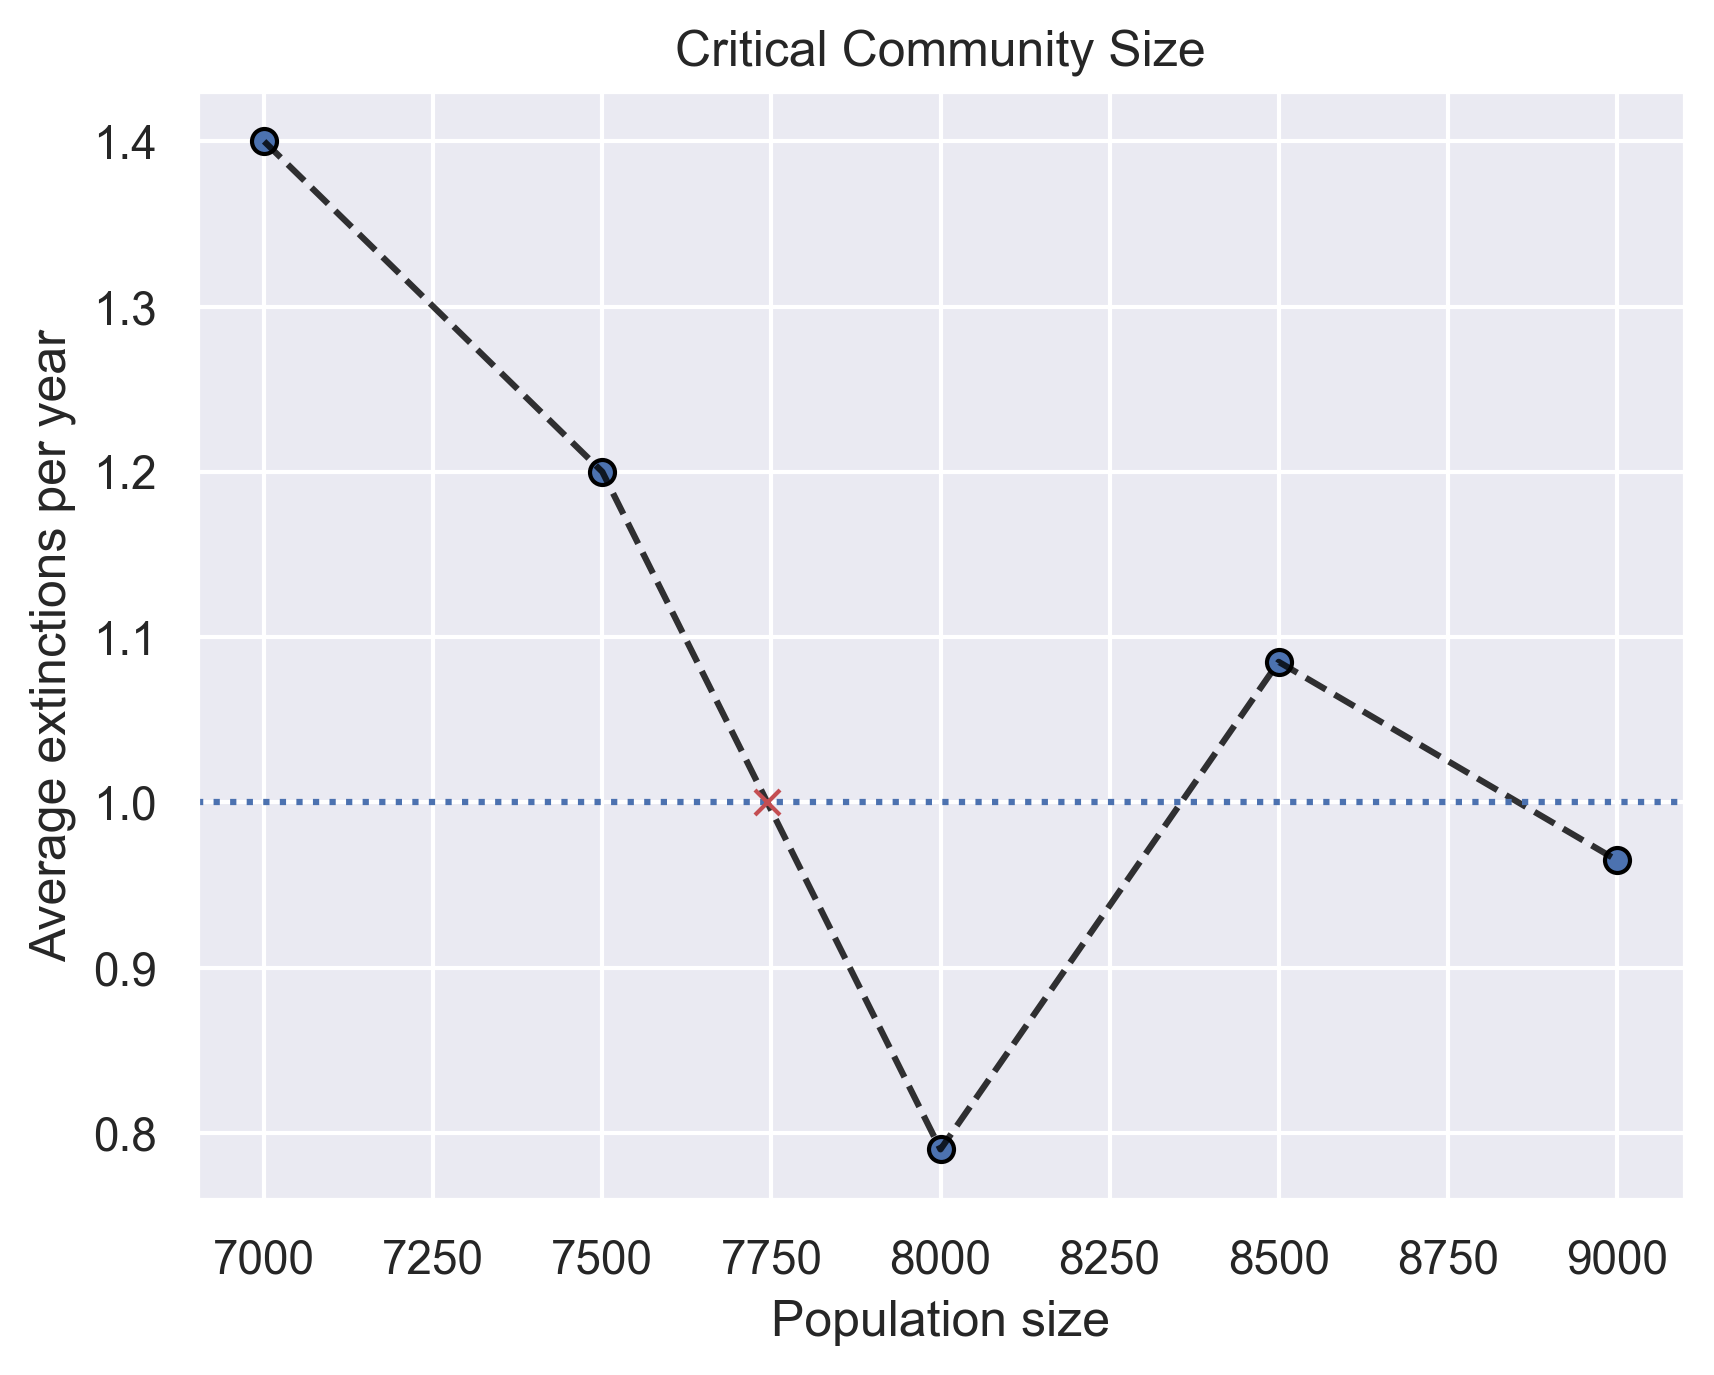

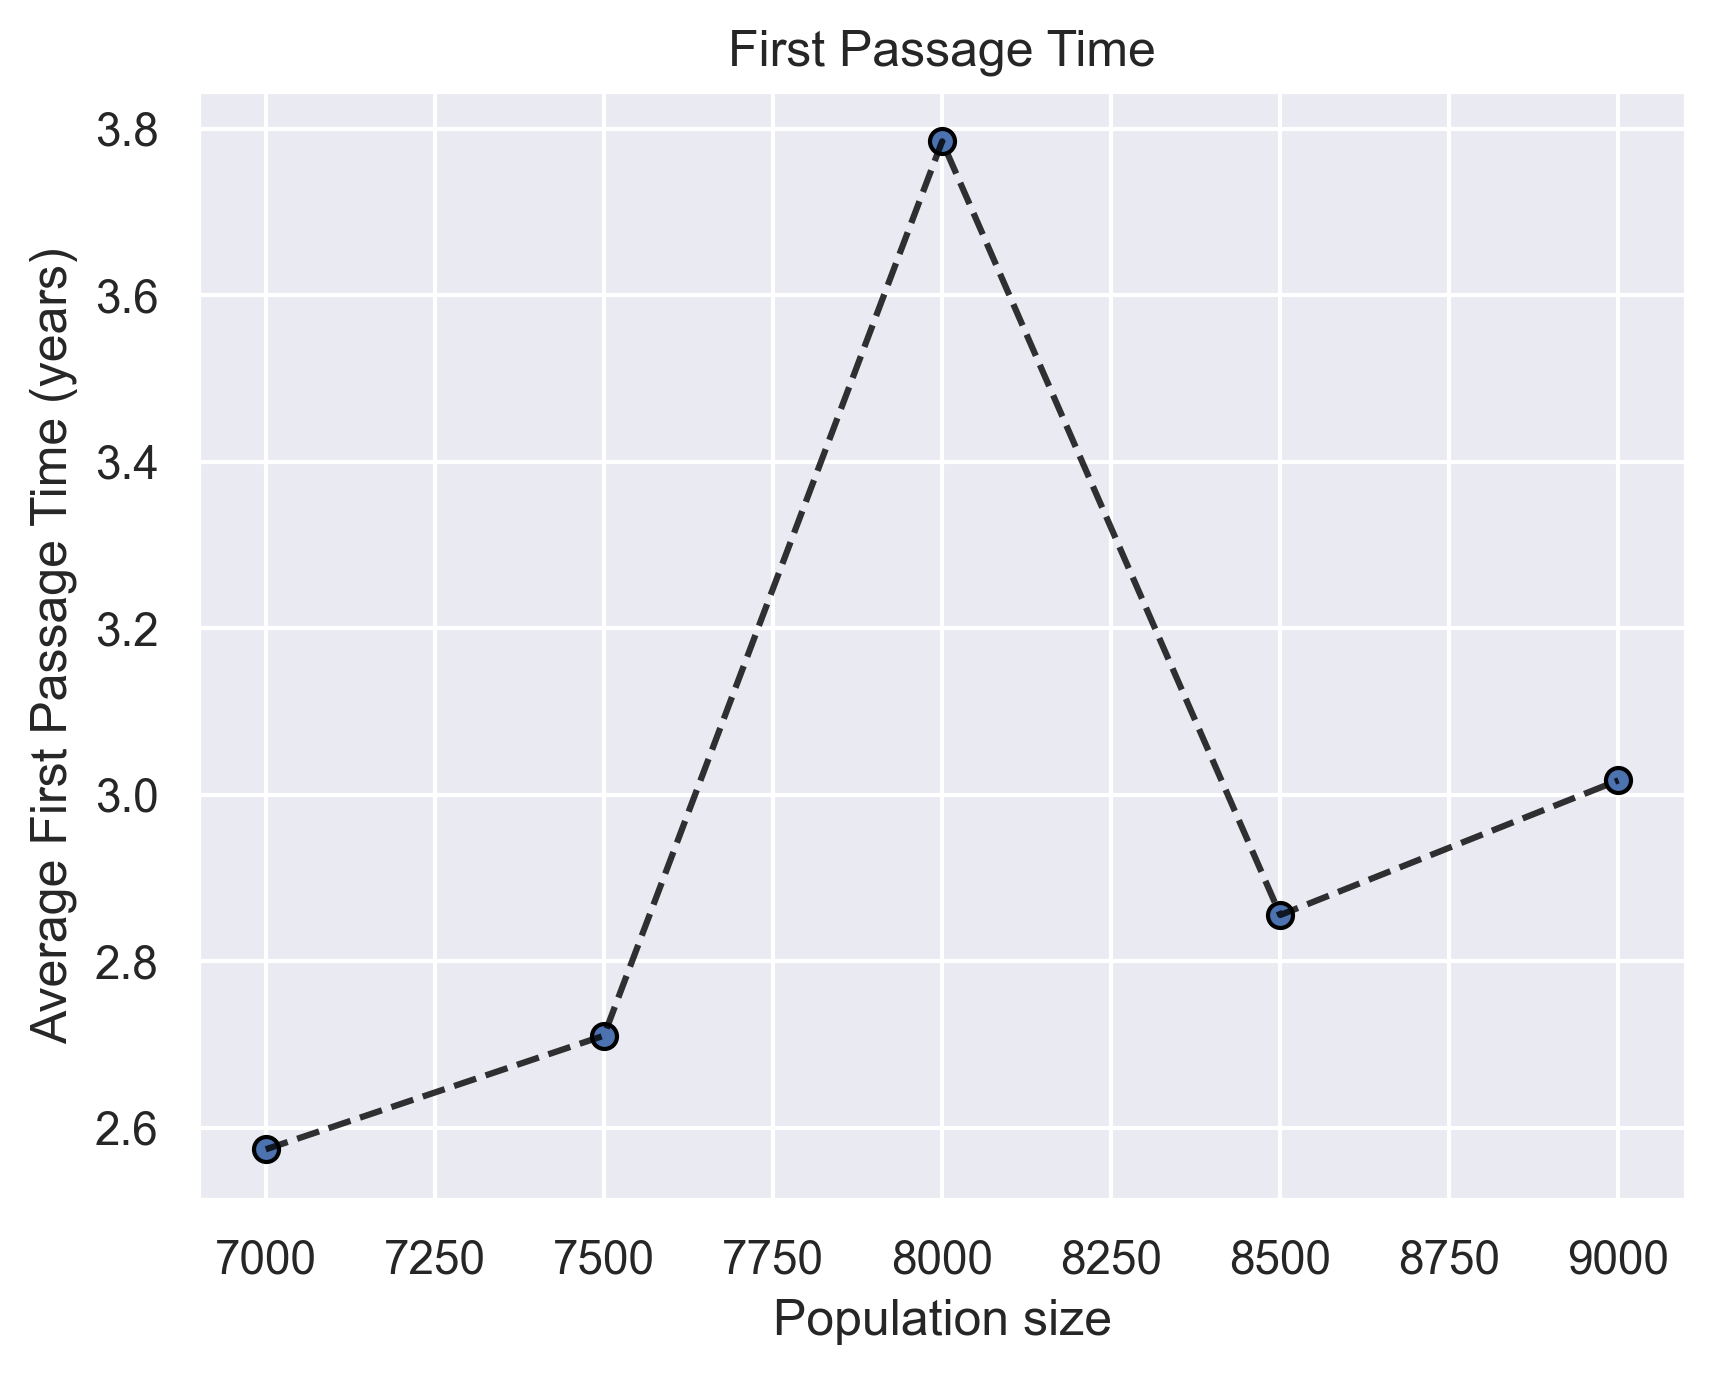

[1.6666666666666667, 2.0, 3.0, 3.3333333333333335, 4.0, 5.0, 6.666666666666667, 10.0, 11.11111111111111, 12.5, 14.285714285714285, 16.666666666666668, 20.0]


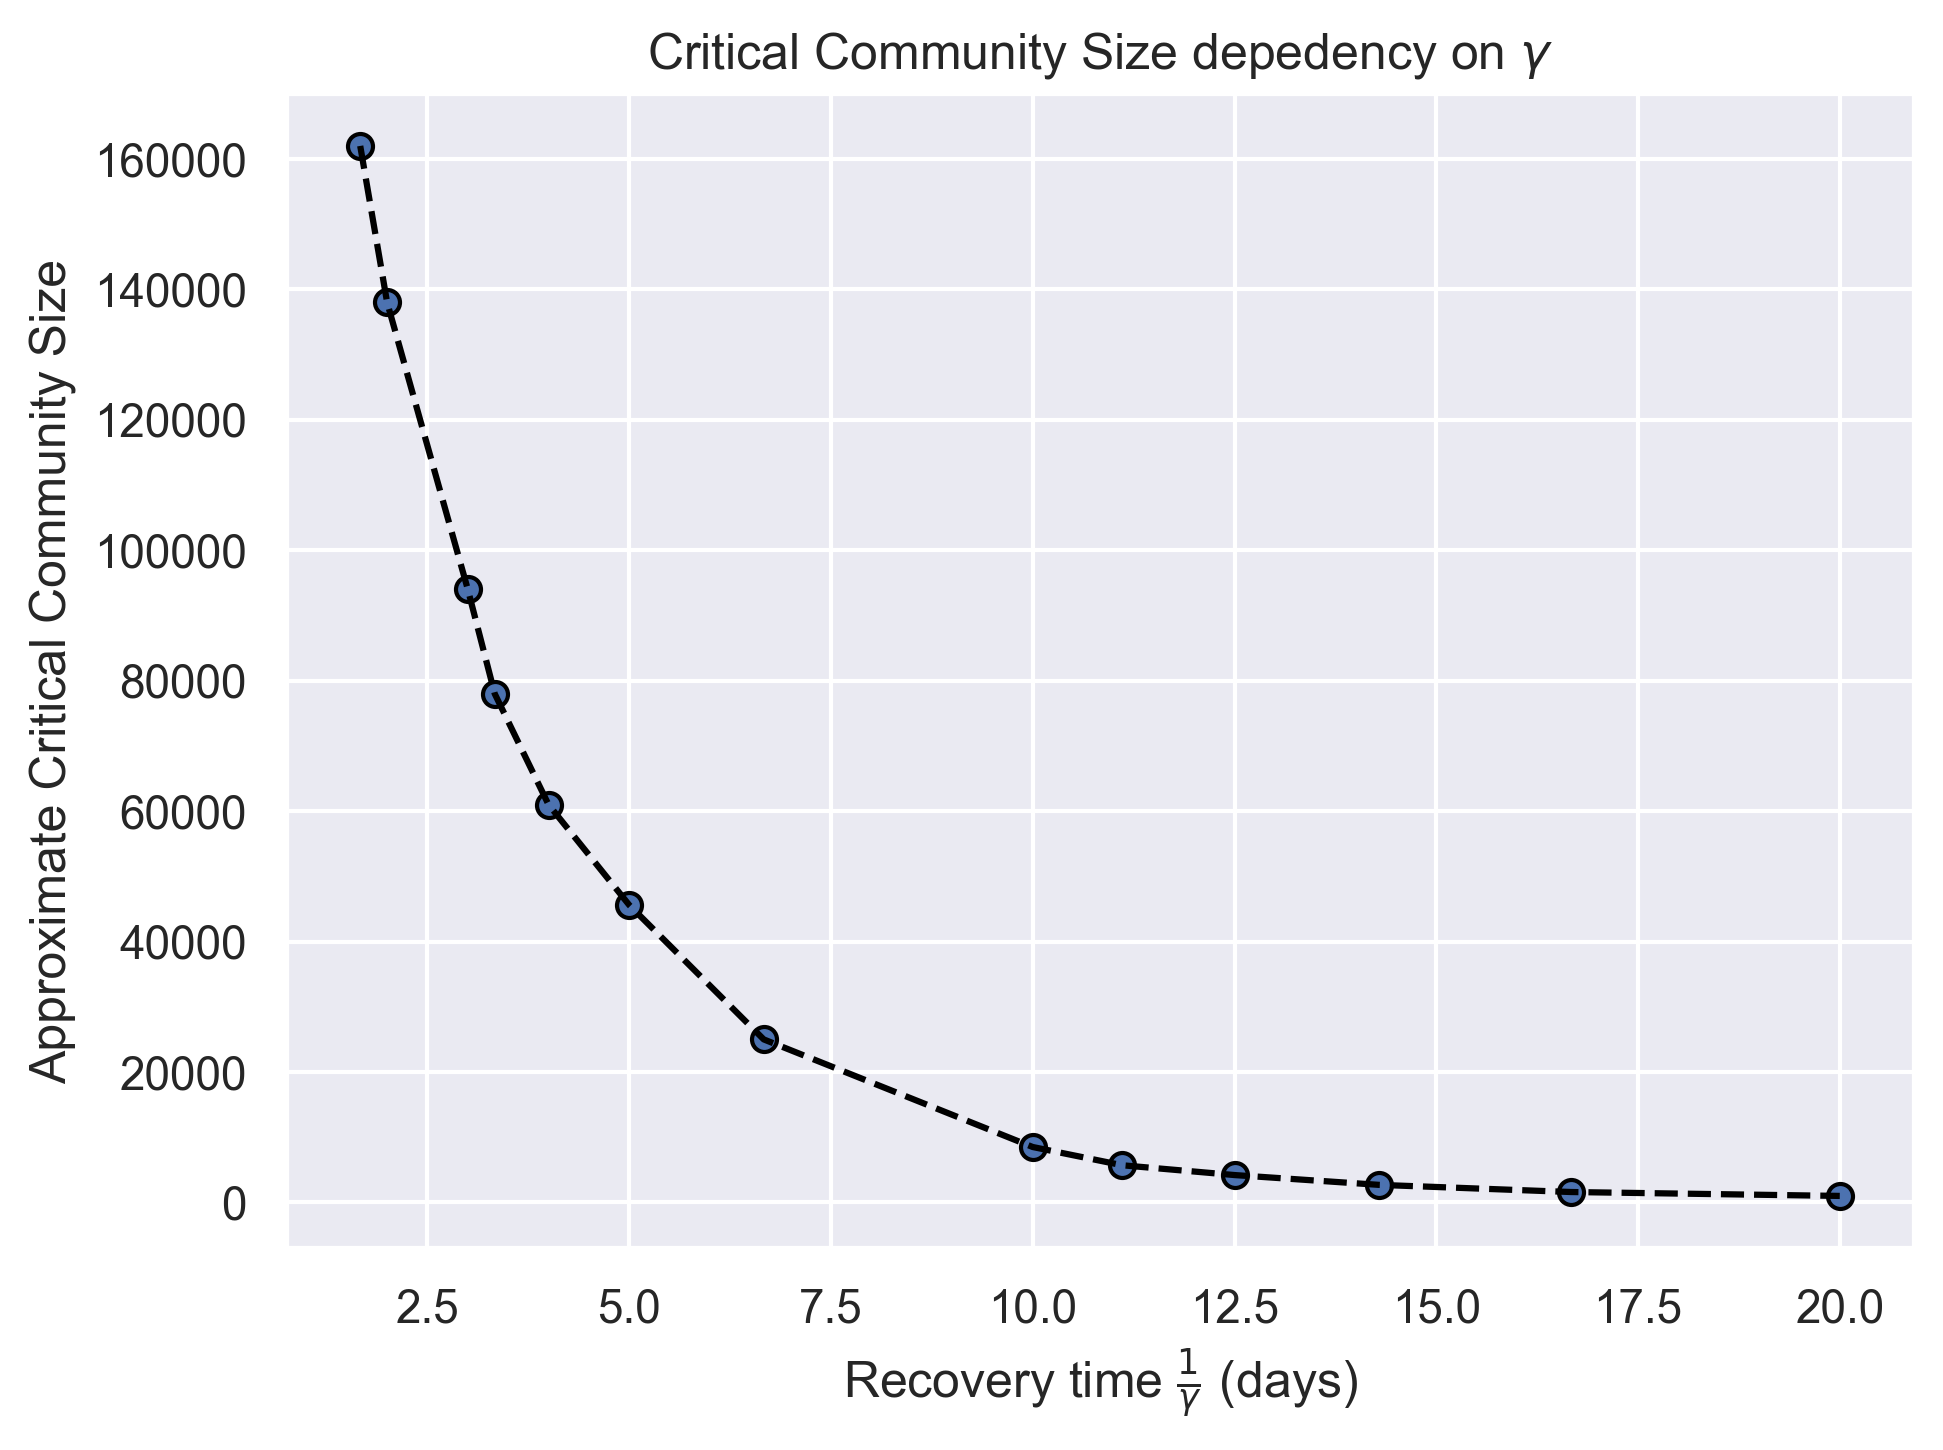

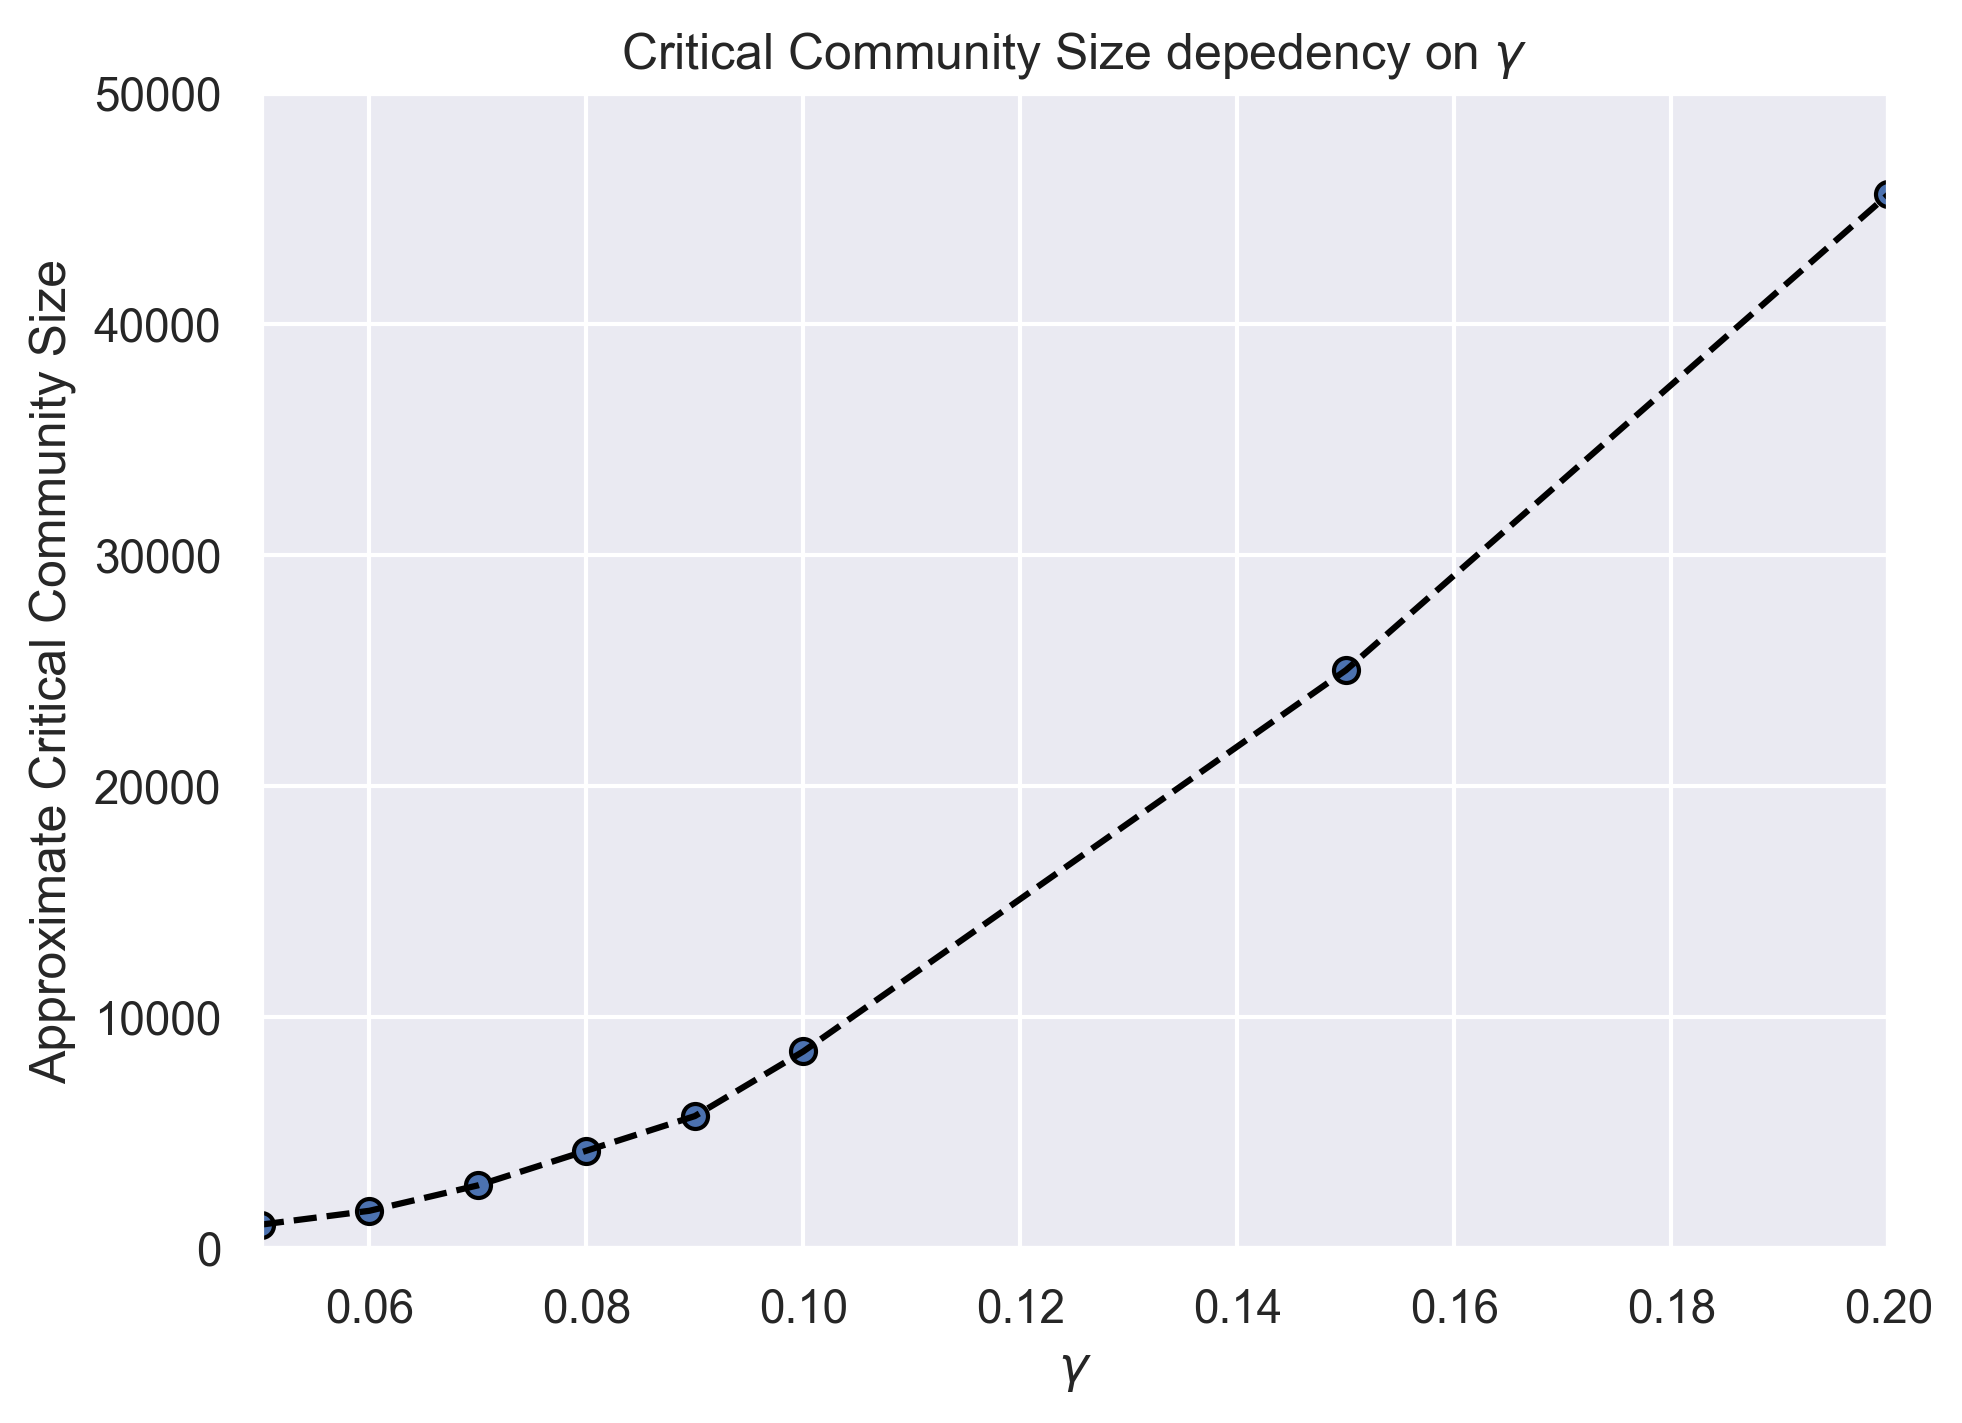

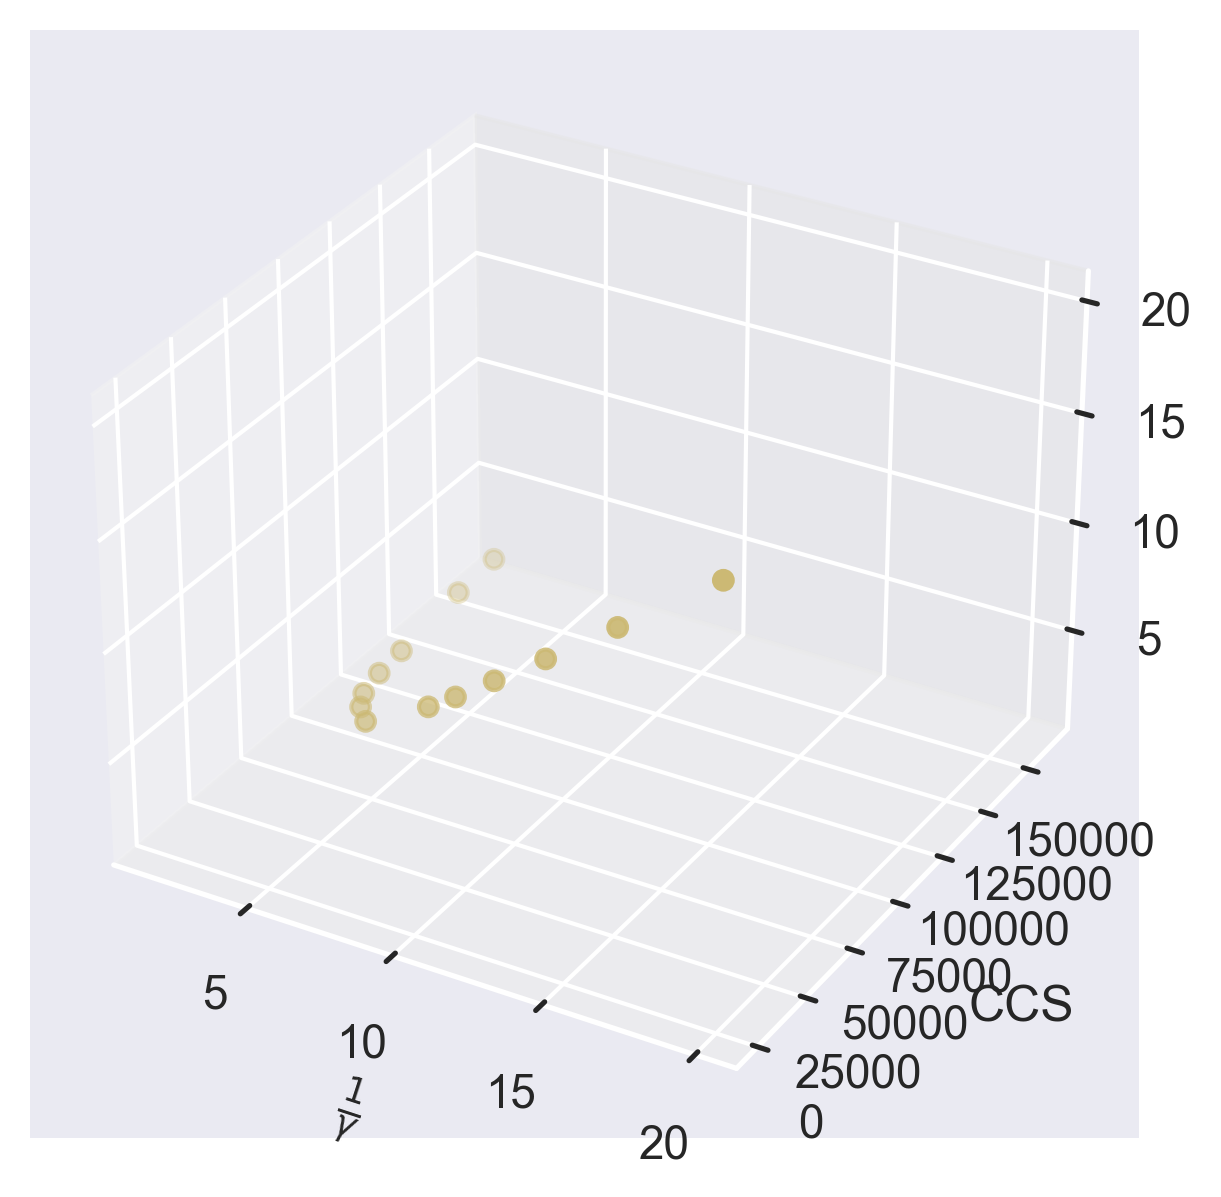

In [7]:

critical_population_list = []
gamma_list = [0.1,0.2,0.3,0.4,0.5,0.6]
gamma_reverse_list = np.array((0.6, 0.5, 1/3, 0.3, 1/4, 0.2, 0.15, 0.1,0.09,0.08,0.07,0.06,0.05))
critical_population_reverse_list = [162000,138000,94000,78000,61000,45600,25000,8500,5700,4200,2700,1600,1000]
gamma_regular_list = [0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,1/4,0.3,1/3,0.5,0.6]
critical_population_regular_list = [1000,1600,2700,4200,5700,8500,25000,45600,61000,78000,94000,138000,162000]

# ccs ~ 50 runs: 8500
gamma = 0.1
populations = [7000,7500,8000,8500,9000]
ccs1 = critical_community(populations,20)
critical_population_list.append(ccs1)

# # ccs ~ 48000; 20 runs: 45.611
# gamma = 0.2
# populations = [40000,45000,52000]
# ccs2 = critical_community(populations,20)
# critical_population_list.append(ccs2)

# ccs ~ 79000 20 runs: 78085
# gamma = 0.3
# populations = [70000,80000,90000]
# ccs3 = critical_community(populations,10)
# critical_population_list.append(ccs3)

# ccs ~ 115000-120000, 10 runs: 121.300
# gamma = 0.4
# populations = [115000,120000,125000,130000]
# ccs4 = critical_community(populations,20)
# critical_population_list.append(ccs4)

# ccs ~  10 runs: 138000
# gamma = 0.5
# populations = [130000,140000,15000]
# ccs5 = critical_community(populations,5)
# critical_population_list.append(ccs5)

# # ccs ~ 5 runs: 162000
# gamma = 0.6
# populations = [155000,160000,170000]
# ccs6 = critical_community(populations,5)
# critical_population_list.append(ccs6)

# plt.figure(figsize = (10,7))
# plt.title(r'Critical community size dependency on $\gamma$')
# plt.plot(gamma_list, critical_population_list, 'bo', markeredgecolor = 'black', alpha = 1 )
# plt.plot(gamma_list, critical_population_list, '--', color = 'black', alpha = 1 )
# plt.ylabel('Critical Community Size')
# plt.xlabel(r'$\gamma$')
# plt.savefig('downloads/ccsgamma.png', dpi = 300)
# plt.show()

# print(critical_population_list)

# ccs ~ 10 runs: 94000
# gamma = 1/3
# populations = [85000,92750,100000]
# ccs0333 = critical_community(populations,10)

# ccs ~ 10 runs: 60782
# gamma = 1/4
# populations = [55000,62000,74000]
# ccs025 = critical_community(populations,10)

# ccs ~ 20 runs: 25000 
# gamma = 0.15
# populations = [20000,27000,35000]
# ccs015 = critical_community(populations,10)

# ccs ~ 20 runs: 5700
# gamma = 0.09
# populations = [5500,6000,6500]
# ccs009 = critical_community(populations,20)

# ccs ~ 20 runs: 4200
# gamma = 0.08
# populations = [4000,4500,5000]
# ccs008 = critical_community(populations,20)

# ccs ~ 30 runs: 2700
# gamma = 0.07
# populations = [2000,2500,3000]
# ccs007 = critical_community(populations,30)

# ccs ~ 30 runs: 1600
# gamma = 0.06
# populations = [1000,1250,1700]
# ccs007 = critical_community(populations,30)


# ccs ~ 20 runs: 1000
# gamma = 0.05
# populations = [500,1000,1500]
# ccs005 = critical_community(populations,30)

gamma = 0.1
R0_list = []
for i in range(len(gamma_reverse_list)):
    R0 = beta/gamma_reverse_list[i]
    R0_list.append(R0)
print(R0_list)

plt.figure(figsize = (7,5))
plt.plot(1/gamma_reverse_list, critical_population_reverse_list,  'bo', markeredgecolor = 'black', alpha = 1 )
plt.plot(1/gamma_reverse_list, critical_population_reverse_list,  '--', color = 'black', alpha = 1 )
plt.xlabel(r'Recovery time $\frac{1}{\gamma}$ (days)')
plt.ylabel('Approximate Critical Community Size')
plt.title(r"Critical Community Size depedency on $\gamma$")
# plt.savefig('downloads/ccs1overgamma.png', dpi=300)
plt.show()

plt.figure(figsize = (7,5))
plt.plot(gamma_regular_list, critical_population_regular_list ,'bo', markeredgecolor = 'black', alpha = 1 )
plt.plot(gamma_regular_list, critical_population_regular_list,  '--', color = 'black', alpha = 1 )
plt.xlabel(r'$\gamma$')
plt.ylabel('Approximate Critical Community Size')
plt.title(r"Critical Community Size depedency on $\gamma$")
plt.xlim(0.05,0.2)
plt.ylim(0,50000)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(1/gamma_reverse_list, critical_population_reverse_list, R0_list, 50, cmap='binary')
ax.scatter(1/gamma_reverse_list, critical_population_reverse_list, R0_list, c='y', marker='o')
ax.set_xlabel(r'$\frac{1}{\gamma}$')
ax.set_ylabel('CCS')
ax.set_zlabel(r'$R_{0}$');





# Meta Population

For subpopulation 1, peak = [10.8476, 3404.00]
For subpopulation 2, peak = [9.6879, 4004.00]
For subpopulation 3, peak = [9.9223, 4155.00]
For subpopulation 4, peak = [10.9536, 4212.00]
For subpopulation 5, peak = [11.5092, 4170.00]
For subpopulation 6, peak = [12.5507, 4241.00]
For subpopulation 7, peak = [13.7247, 4182.00]
Relative delay between epidemic peak of sub-population 2 w.r.t. sub-population 1 = -1.1596 days 
Relative delay between epidemic peak of sub-population 3 w.r.t. sub-population 2 = 0.2344 days 
Relative delay between epidemic peak of sub-population 4 w.r.t. sub-population 3 = 1.0313 days 
Relative delay between epidemic peak of sub-population 5 w.r.t. sub-population 4 = 0.5556 days 
Relative delay between epidemic peak of sub-population 6 w.r.t. sub-population 5 = 1.0415 days 
Relative delay between epidemic peak of sub-population 7 w.r.t. sub-population 6 = 1.1740 days 
The average delay is 0.41 
The sub-population peak-time order is [2 3 1 4 5 6 7]
The sub-populat

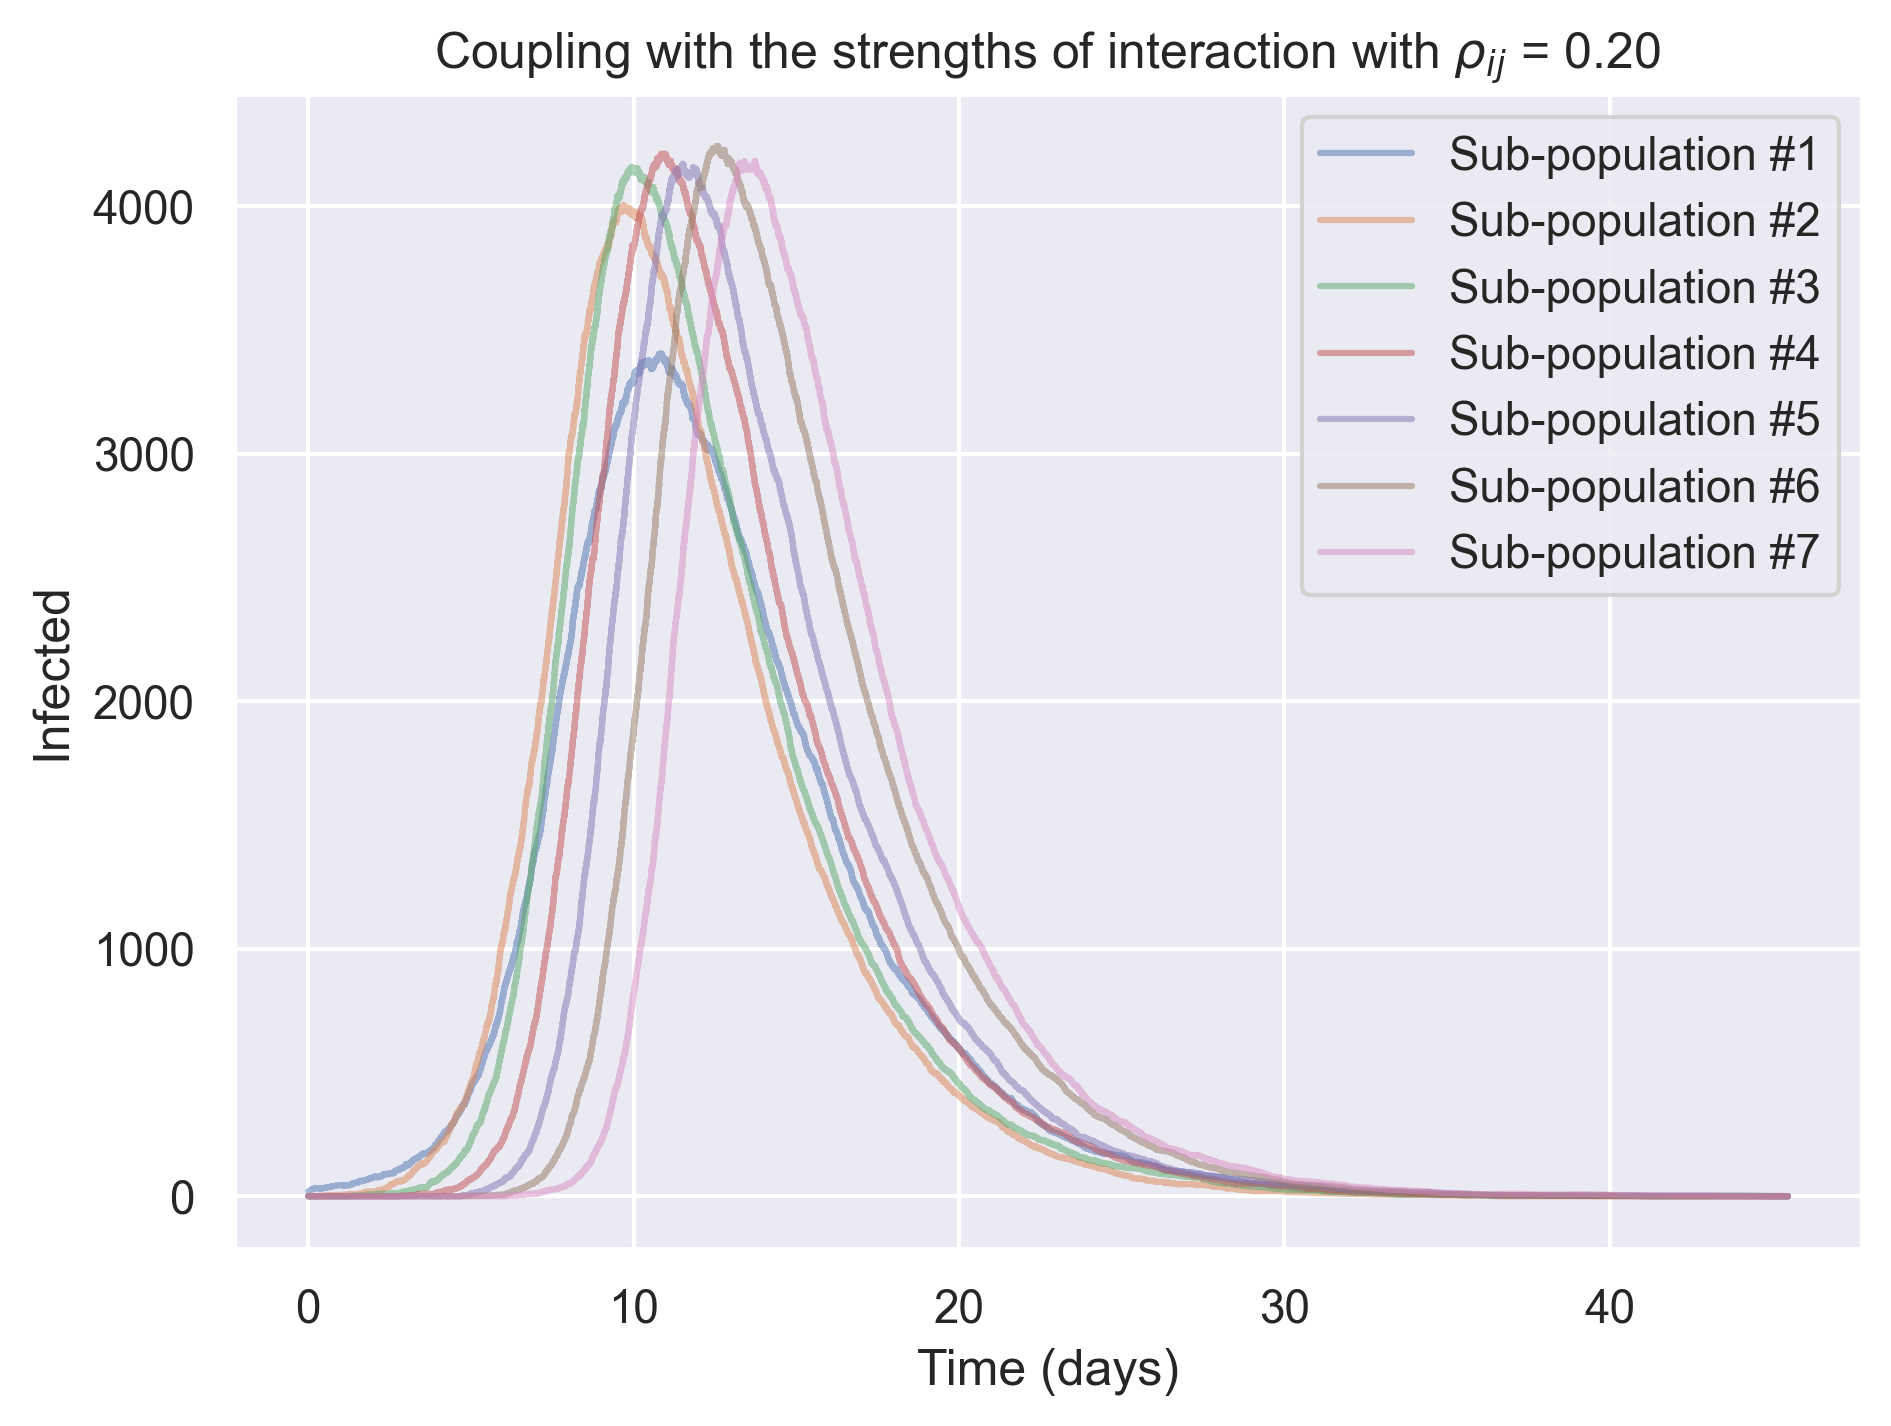

The average delay is 0.55 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 1/10 complete 

The average delay is 0.47 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 2/10 complete 

The average delay is 0.44 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 3/10 complete 

The average delay is 0.49 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 4/10 complete 

The average delay is 0.36 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 5/10 complete 

The average delay is 0.41 
The sub-population peak-time order is [3 2 1 4 5 6 7]
Run 6/10 complete 

The average delay is 0.46 
The sub-population peak-time order is [2 1 3 4 5 6 7]
Run 7/10 complete 

The average delay is 0.50 
The sub-population peak-time order is [2 3 1 4 5 6 7]
Run 8/10 complete 

The average delay is 0.28 
The sub-population peak-time order is [3 2 4 1 5 6 7]
Run 9/10 complete 

The average delay is 0.35 
The sub-population peak-time order is [2 3 4 1 5 6 7]
Run 10/10 

0.4287072877491135

In [9]:
def stoc_eqs_met(INP,t_next): 
    '''
    Stochastic equations for the meta-population model
    '''
    V = INP
    change = np.zeros((nsub,2,3))
    sumlambda = np.zeros((nsub))
    rate = np.zeros((nsub,2))
    
    # determine the events and it changes to X Y and Z for each subpopulation
    for sub in range(nsub): 
        N = np.sum(V[sub])
        for subs in range(nsub):
            if N == 0:
                sumlambda[sub] = 0 
            sumlambda[sub] += rho[sub][subs]*V[subs][1]/N
        rate[sub][0] = beta*sumlambda[sub]*V[sub][0]
        rate[sub][1] = gamma*V[sub][1]
        change[sub] = np.array([[-1, +1, 0], [0, -1, +1]])
    
    R1 = random.random()
    R2 = random.random()
    
    sum_rates_list = np.cumsum(rate)
    for i in range(len(sum_rates_list)):
        if sum_rates_list[i] >= R1*np.sum(rate):
            sub = i//2
            V[sub] = V[sub] + change[sub][i%2]
            break
            
    t_next = -np.log(R2)/(np.sum(rate));
    return [V,t_next]


def meta_SIR(INP):
    '''
    Stochastic iteration for the meta-populaton SIR model
    '''
    
    lop=0
    t_next=0
    T=[0]
    S=[[0] for x in range(nsub)]
    I=[[0] for x in range(nsub)]
    R=[[0] for x in range(nsub)]
    while T[lop] < t_max:
        lop=lop+1
        T.append(T[lop-1]+t_next)
        for sub in range(nsub):
            S[sub].append(INP[sub][0])
            I[sub].append(INP[sub][1])
            R[sub].append(INP[sub][2])
        [res,t_next] = stoc_eqs_met(INP,t_next)
    
    tT=np.array(T)
    tS=np.array(S)
    tI=np.array(I)
    tR=np.array(R) 
        
    return [tT,tS,tI,tR]
    
# Parameters for sub-populations
t_max = 1 * 365
N0 = 10000
beta = 1 
gamma = 0.3

# Meta-population parameters that are varied to obtain crucial understanding of meta-population models
rho_ij = 0.2
nsub = 7


rho = np.zeros((nsub,nsub))
for pop in range(nsub):                    
    for sub in range(nsub):
        if pop == sub:
            rho[pop][sub] = 1
            if pop < nsub-1:
                rho[pop+1][sub] = rho_ij        

# Initial conditions for subpopulation i
Y01 = 20
X01 = N0 - Y01
Z01 = N0 - X01 - Y01

# initial conditions for subpopulations j which are all fully susceptible initially
Y02 = 0 
X02 = N0 - Y02
Z02 = N0 - X02 - Y02

INPUT01 = [[X01,Y01,Z01]]
INPUT = INPUT01 + [[X02,Y02,Z02] for initials in range(nsub-1)]
[tT,tS,tI,tR] = meta_SIR(INPUT)


timestep = 0.0

# Plotting
plt.figure(figsize=(7, 5))
plt.title(r'Coupling with the strengths of interaction with $\rho_{ij}$ = %.2f '%(rho_ij))
plt.xlabel('Time (days)')
plt.ylabel('Infected')

# Find information about the epidemic peaks
t_peaks_sub = []
I_peaks_sub = []
for sub in range(nsub):                            
    plt.plot(tT[1:], tI[sub][1:], alpha = 0.5, label=(f'Sub-population #{sub+1}'))
    
    I_peak = 0
    for i in range(len(tT[1:])):
        if tI[sub][1:][i] > I_peak:
            I_peak = tI[sub][1:][i]
            t_peak = tT[1:][i]
    t_peaks_sub.append(t_peak)
    I_peaks_sub.append(I_peak)
    print('For subpopulation %.i, peak = [%.4f, %.2f]'%(sub + 1,t_peak,I_peak))

# Calculate the delay and relative delay between each peak and its neighbor in an n-subpopulation system
sum_relative_delay = 0
for i in range(1, len(t_peaks_sub)):
    t_ref = t_peaks_sub[0]
    delay = t_peaks_sub[i] - t_ref
    relative_delay = t_peaks_sub[i] - t_peaks_sub[i-1]
    sum_relative_delay += relative_delay

    #     print('Delay between epidemic peak of sub-population %i w.r.t. sub-population 1 = %.4f days '%(i + 1, delay))
    print('Relative delay between epidemic peak of sub-population %i w.r.t. sub-population %i = %.4f days '%(i + 1, i, relative_delay))

avg_relative_delay = sum_relative_delay/len(t_peaks_sub)

# Print statements for the avergae relative delay, and the peak sequences from earliest to latest
print('The average delay is %.2f '%(avg_relative_delay))
print('The sub-population peak-time order is %s'%(np.array(np.argsort(t_peaks_sub))+1))
print('The sub-population peak-amplitude order is %s'%(np.array(np.argsort(I_peaks_sub))+1))

# Demonstrate plot
plt.legend(loc=1)
# plt.savefig(f'downloads/metapopulation{nsub}.png',dpi=300)
plt.show()



def delay(runs):
    '''
    Calculates the average relative delay between epidemic peaks of sub-populations and its neighbors
    averaged over several runs. The peak sequence is also printed.
    '''
    avg_relative_delay_sum = 0

    # Re-iterate stochatic meta equations for each run to later find an average
    for run in range(runs):
        
        # Initial conditions for subpopulation i
        Y01 = 20
        X01 = N0 - Y01
        Z01 = N0 - X01 - Y01

        # Initial conditions for subpopulations j which are all fully susceptible initially
        Y02 = 0 
        X02 = N0 - Y02
        Z02 = N0 - X02 - Y02

        INPUT01 = [[X01,Y01,Z01]]
        INPUT = INPUT01 + [[X02,Y02,Z02] for initials in range(nsub-1)]
        
        [tT,tS,tI,tR] = meta_SIR(INPUT)
        
        # Find coordinates of epidemic peaks of sup-populations
        t_peaks_sub = []
        I_peaks_sub = []
    
        for sub in range(nsub):                            
            I_peak = 0
            for i in range(len(tT[1:])):
                if tI[sub][1:][i] > I_peak:
                    I_peak = tI[sub][1:][i]
                    t_peak = tT[1:][i]
            t_peaks_sub.append(t_peak)
            I_peaks_sub.append(I_peak)
        
        # For each sub-population i calculate the time difference between a peak, and its neighbor i - 1's peak
        sum_relative_delay = 0
        for i in range(1, len(t_peaks_sub)):
            t_ref = t_peaks_sub[0]
            delay = t_peaks_sub[i] - t_ref
            relative_delay = t_peaks_sub[i] - t_peaks_sub[i-1]
            sum_relative_delay += relative_delay
        
        # Average for all sub-populations
        avg_relative_delay = sum_relative_delay/len(t_peaks_sub)
        avg_relative_delay_sum += avg_relative_delay
        
        # Print statements per run to show the average relative delay and the sequence of peaks.
        print('The average delay is %.2f '%(avg_relative_delay))
        print('The sub-population peak-time order is %s'%(np.array(np.argsort(t_peaks_sub))+1))
        print('Run %i/%i complete \n'%(run+1,runs))
        
    # Average the average relative delay over all sub-populations, over all runs, and print and return result   
    avg_relative_delay_runs = avg_relative_delay_sum/runs
    print('The average relative delay = %.3f days, over %i runs for %i sub-populations with rho_{ij} = %.3f'%(avg_relative_delay_runs, runs, nsub, rho_ij))
    
    return(avg_relative_delay_runs)
    
delay(10)
